<a href="https://colab.research.google.com/github/Abdulhamid97Mousa/1D_CNN_VibrationSignal_BearingFaultDiagnosis/blob/main/Bearing_Fault_Diagnosis_using_Convolutional_Neural_Networks_and_Vibration_Spectrogram_CWRU_DS_10_Classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bearing Fault Diagnosis using Convolutional Neural Networks and Vibration Spectrogram


https://www.mdpi.com/2076-3417/10/18/6385/htm
the proposed method, vibration signals are represented by
spectrograms to apply deep learning methods through preprocessing using Short-Time Fourier
Transform (STFT). Then, feature extraction and health status classification are performed by a
convolutional neural network (CNN), Resnet18. According to various experiments, our proposed
method can achieve very high accuracy and robustness for bearing fault diagnosis even under
noisy environments.

# 1. Introduction
The dataset that have been used here are - CWRU

* The first dataset is from the Case Western Reserve University. This is used to classify faults using a CNN (Convolutional Neural Network).



## 1.1 Import Necessary Libraries
We'll be using the following libraries to complete our classification problem:

*  Numpy - For linear algebra operations
*  Torch - Pytorch Deep Learning Framework
*  Torch NN - Neural network class from Pytorch library
*  Torch NN Functional - Functional Neural Network class from Pytorch library
*  Torch Utils Data: DataLoader, Dataset - Dataset class used to create custom dataset class by subclassing it and DataLoader is used to laod data in batches using dataset class in real-time.
*  Torchvision: Transforms, Models - Trochvision provides augmentation techniques using transforms class and transfer learning models are available in models class
*  OS - To use Operating System methods
*  Random - To set random seed at specific places where random operations take place just so it happens the same way everytime it is executed
*  Pandas - To create DataFrame, CSV files, etc
*  Time - To perform date time operations


*  Scikit-Learn - For evaluating our Classifier and for cross-validation split
*  matplotlib - To visualize images, losses and accuracy
*  Google Colab Drive - To mount Google Drive so we can perform storage and loading operations using it

In [ ]:
pip install libfmp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#@title Import Necessary Packages
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

import errno
import requests
import scipy.io as sio

from os import listdir
from os.path import isfile, join
from zipfile import ZipFile 
from sklearn.model_selection import train_test_split

# Others
from IPython.core.debugger import set_trace
from pathlib import Path

from scipy import signal
from skimage.transform import resize
from numpy import asarray
from numpy import clip
from scipy.fft import fftshift
import skimage, sklearn

# Pytorch
import torch
from torch import nn
from torch.nn import functional as F
from torch import Tensor
from torch.nn.modules.loss import CrossEntropyLoss
from torchvision import models
from torch import optim, cuda
from torch.utils.data import  sampler
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
from torchvision import datasets,transforms

from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import MultiLabelBinarizer
from itertools import cycle

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Image manipulations
from PIL import Image
# Useful for examining network
from torchsummary import summary
# Timing utility
from timeit import default_timer as timer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print(os.getcwd())
filename = os.path.join(os.getcwd(), 'repo.zip')
print(filename)

/content
/content/repo.zip


# 2. Download the dataset - CWRU
The dataset is downloaded from the Github repository. The dataset has several matlab files where the name is just a number (such as "118.mat"). It has information such as

### State :
- N for normal state, not damaged
- B for ball damage
- IR for inner raceway damage
- OR for outer raceway damage

### Fault Diameter -
* 007 for 0.007 inch damage
* 014 for 0.014 inch damage
* 021 for 0.021 inch damage
* 028 for 0.028 inch damage

the dataset has the unit 'mils' is 1/1000th of an inch
### Position of the sensor
- 3, 6, 12 for outer raceway faults located at 3 o’clock, at 6 o’clock and at 12 o’clock respectively of the load zone

### Load can be:
* 0, 1, 2, 3 for different motor load conditions in Horsepower (HP)

In [ ]:
url = 'https://github.com/Abdulhamid97Mousa/CWRU-dataset-1/archive/refs/heads/main.zip'

r = requests.get(url)

print(filename)

with open(filename, 'wb') as f:
    f.write(r.content) 

file_name = "/content/repo.zip"
with ZipFile(file_name, 'r') as zip: 
    # printing all the contents of the zip file 
  
    # extracting all the files 
    print('Extracting all the files now...') 
    zip.extractall() 
    print('Finished Extracting!') 

/content/repo.zip
Extracting all the files now...
Finished Extracting!


# 3. Edit the downloaded data

## 3.1 Functions used:

`For modularized Code you can create a .py file and dump all these function in it, and just call them whenever needed. i've intentionally put them here so i can quickly analyze my code, codos to whomever is reading this code.`


Using the data collected at the *`Drive End`*, which is labeled as the code `DE`, this function picks up the time signal from a file. For the given code, a regex is made on the dictionary keys, looking for the the code and ignoring the rest of the suffix. 

The function also converts the inch unit to SI.

In [ ]:
import re
def acceleration_time_signal(dict_1, code):
    """
    load the time series in the file and convert units in SI
    file= 'filename' from the ./dataset/ folder
    code= ' DE' or 'FE', other code will give error
    """
    
    try:
        for key in dict_1:
            # print(key)
            if re.findall(rf"({code})", key):
                dict_code = key
        #inches to meter
        unit_conv = 0.0254
        x = dict_1[dict_code] * unit_conv
        return x
    except:
        print('File does not exist or code wrong. Code must be either "DE or "FE" ')

- 3 different functions are necessary to process the files and the data
- All subfolders scanned recursively with the function `fast_scandir` 

In [ ]:
def Read_MAT_files_from_folders(file_path, files_list, code):
  G_data = []
  for i in range(len(files_list)):
    data = sio.loadmat(os.path.join(file_path, files_list[i]))
    sig = acceleration_time_signal(data, code)
    # print('what is signal type and sig len and signal shape', type(sig), len(sig), sig.shape)
    G_data.append(sig)
  
  G_data = np.vstack(G_data).flatten()
  # print("what is G_data", G_data)
  return G_data 

def Percent_data_split(array_1, array_2, percent_1 = 10, index_1 = False):
  if index_1 == False:
    #splitting FE data by percent 
    len_n = array_1.shape[0]
    percent_true = percent_1/100
    x = int(percent_true*len_n) #% split
    data_percent, data_rest = np.split(array_1, [x])
  else:
    #splitting array_1 data by percent of array_2 data
    len_n = array_2.shape[0]
    percent_true = percent_1/100
    x = int(percent_true*len_n) #% split
    data_percent, data_rest = np.split(array_1, [x])

  return data_percent, data_rest

def fast_scandir(dirname):
    subfolders= [f.path for f in os.scandir(dirname) if f.is_dir()]
    for dirname in list(subfolders):
        subfolders.extend(fast_scandir(dirname))
    
    return subfolders 

# 3.2 Dataset Partitioning
## 3.2.1 Normal Baseline data 

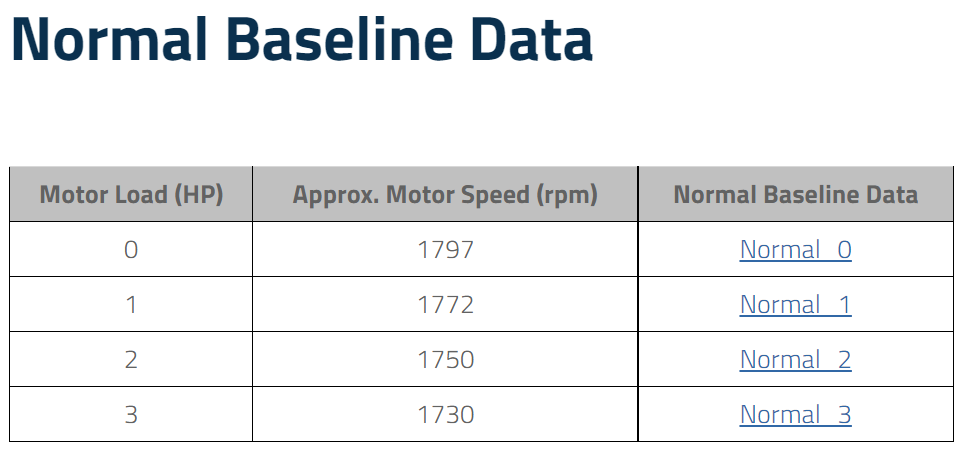

In [ ]:
#@title Default title text
#12k Normal Signal for DE
file_path_1 = '/content/CWRU-dataset-1-main/Normal'
onlyfiles_1 = [f for f in listdir(file_path_1) if isfile(join(file_path_1, f))]

print(onlyfiles_1)
print(type(onlyfiles_1))
print(len(onlyfiles_1))

G_data_N_DE = Read_MAT_files_from_folders(file_path_1, onlyfiles_1, "DE")
display(G_data_N_DE.shape)
print(type(G_data_N_DE))

['100_Normal_3.mat', '99_Normal_2.mat', '98_Normal_1.mat', '97_Normal_0.mat']
<class 'list'>
4


(1698547,)

<class 'numpy.ndarray'>


### 3.2.2 Faulty Bearing Data at DE: 12000 Hz DE  
`12k is the sampling rate fs` 

1. B `Ball Bearing Faulty signal`
2. IR `Ball Bearing Inner race Faulty signal`
3. OR `Ball Bearing Outer race Faulty signal`

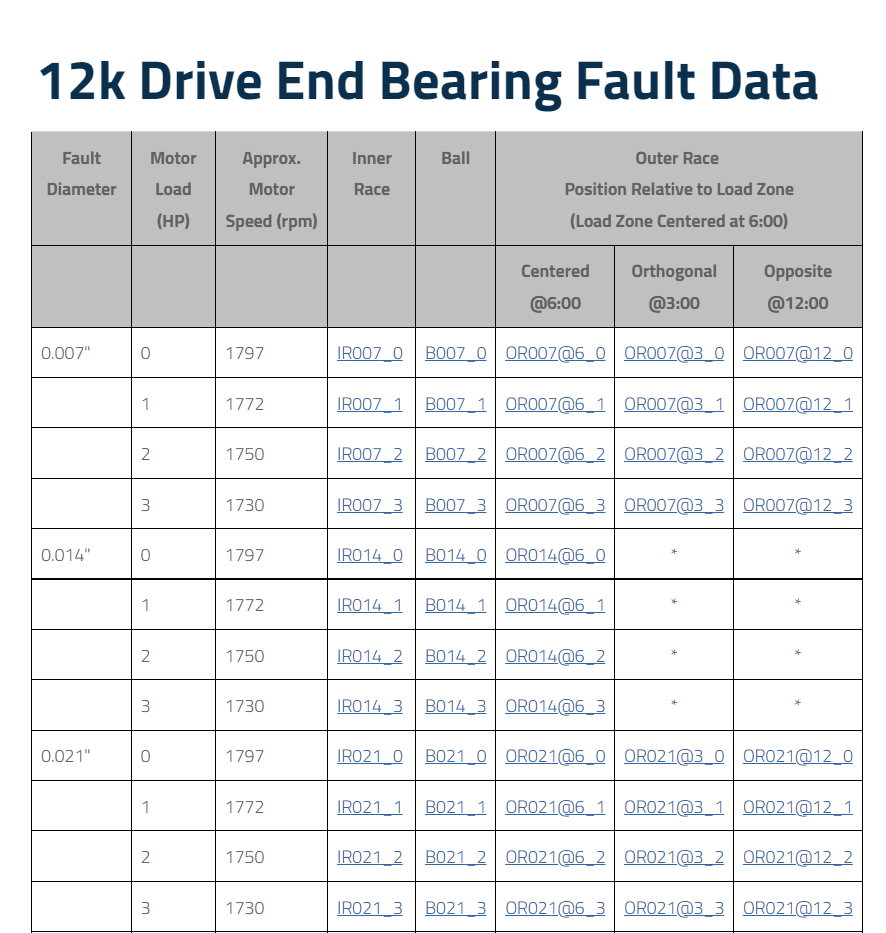

In [ ]:
#@title Default title text
#12k DE data load
file_path_2 = '/content/CWRU-dataset-1-main/12k_Drive_End_Bearing_Fault_Data'
subfolder_path = fast_scandir(file_path_2)

G_data_OR_007_DE = []
G_data_OR_021_DE = []

for i in range(3, len(subfolder_path), 1):
  dir_1 = subfolder_path[i]
  # print(subfolder_path[i])
  #B
  if 'B/' in dir_1:
    onlyfiles_2_1 = [f for f in listdir(dir_1) if isfile(join(dir_1, f))]

    if '007' in dir_1:
    #007
      G_data_B_007_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_1, "DE")
    elif '014' in dir_1:
    #014
      G_data_B_014_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_1, "DE")
    elif '021' in dir_1:
    #021
      G_data_B_021_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_1, "DE")
    else:
    #028
      G_data_B_028_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_1, "DE")


  #IR
  elif 'IR/' in dir_1:
    onlyfiles_2_2 = [f for f in listdir(dir_1) if isfile(join(dir_1, f))]

    if '007' in dir_1:
    #007
      G_data_IR_007_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_2, "DE")
    elif '014' in dir_1:
    #014
      G_data_IR_014_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_2, "DE")
    elif '021' in dir_1:
    #021
      G_data_IR_021_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_2, "DE")
    else:
    #028
      G_data_IR_028_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_2, "DE")


  #OR
  elif 'OR/' in dir_1:
    
    onlyfiles_2_3 = [f for f in listdir(dir_1) if isfile(join(dir_1, f))]
    
    if '007' in dir_1:

      #007
      for i in range(len(onlyfiles_2_3)):
        data_OR_007 = sio.loadmat(os.path.join(dir_1, onlyfiles_2_3[i]))
        or_sig_007 = acceleration_time_signal(data_OR_007, code='DE')
        G_data_OR_007_DE.append(or_sig_007)

      #014  
    elif '014' in dir_1:
      G_data_OR_014_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_3, "DE")


      #021
    else:
      for i in range(len(onlyfiles_2_3)):
        data_OR_021 = sio.loadmat(os.path.join(dir_1, onlyfiles_2_3[i]))
        or_sig_021 = acceleration_time_signal(data_OR_021, code='DE')
        G_data_OR_021_DE.append(or_sig_021)


In [ ]:
#@title Default title text
print("G_data_B_007_DE", G_data_B_007_DE.shape)
print("G_data_B_014_DE", G_data_B_014_DE.shape)
print("G_data_B_021_DE", G_data_B_021_DE.shape)
print("G_data_B_028_DE", G_data_B_028_DE.shape)
G_data_B_DE = np.concatenate((G_data_B_007_DE, G_data_B_014_DE, G_data_B_021_DE), axis=0).flatten()
print("G_data_B_DE", G_data_B_DE.shape)
print("G_data_B_DE type", type(G_data_B_DE))

print("G_data_IR_007_DE", G_data_IR_007_DE.shape)
print("G_data_IR_014_DE", G_data_IR_014_DE.shape)
print("G_data_IR_021_DE", G_data_IR_021_DE.shape)
print("G_data_IR_028_DE", G_data_IR_028_DE.shape)
G_data_IR_DE = np.concatenate((G_data_IR_007_DE, G_data_IR_014_DE,
                               G_data_IR_021_DE), axis=0).flatten()
print("G_data_IR_DE", G_data_IR_DE.shape)

G_data_OR_007_DE = np.vstack(G_data_OR_007_DE).flatten()
print("G_data_OR_007_DE", G_data_OR_007_DE.shape)
G_data_OR_014_DE = np.vstack(G_data_OR_014_DE).flatten()
print("G_data_OR_014_DE", np.shape(G_data_OR_014_DE))
G_data_OR_021_DE = np.vstack(G_data_OR_021_DE).flatten()
print("G_data_OR_021_DE", G_data_OR_021_DE.shape)
G_data_OR_DE = np.concatenate((G_data_OR_007_DE, G_data_OR_014_DE, 
                               G_data_OR_021_DE), axis=0).flatten()
print("G_data_OR_DE", np.shape(G_data_OR_DE))  
print("G_data_N_DE.shape", G_data_N_DE.shape)

# 
G_data_faulty = np.concatenate((G_data_B_007_DE, G_data_B_014_DE, G_data_B_021_DE, G_data_IR_007_DE,
                                G_data_IR_014_DE, G_data_IR_021_DE, G_data_OR_007_DE, G_data_OR_014_DE, G_data_OR_021_DE), axis=0).flatten()
print("G_data_faulty.shape", G_data_faulty.shape)       

G_data_B_007_DE (487093,)
G_data_B_014_DE (488109,)
G_data_B_021_DE (487964,)
G_data_B_028_DE (484120,)
G_data_B_DE (1463166,)
G_data_B_DE type <class 'numpy.ndarray'>
G_data_IR_007_DE (488309,)
G_data_IR_014_DE (487239,)
G_data_IR_021_DE (487529,)
G_data_IR_028_DE (485038,)
G_data_IR_DE (1463077,)
G_data_OR_007_DE (1465051,)
G_data_OR_014_DE (487819,)
G_data_OR_021_DE (1465487,)
G_data_OR_DE (3418357,)
G_data_N_DE.shape (1698547,)
G_data_faulty.shape (6344600,)


In [ ]:
print("Level #1 Bearing Status")
print("G_data_N_DE.shape", G_data_N_DE.shape)
print("G_data_faulty.shape", G_data_faulty.shape) 

print("Level #2 Bearing Fault Location")
print("G_data_N_DE.shape", G_data_N_DE.shape)
print("G_data_B_DE", G_data_B_DE.shape)
print("G_data_IR_DE", G_data_IR_DE.shape)
print("G_data_OR_DE", np.shape(G_data_OR_DE))

print("Level #3 Bearing Fault Diameter")
print("G_data_N_DE.shape", G_data_N_DE.shape)
print("G_data_B_007_DE", G_data_B_007_DE.shape)
print("G_data_B_014_DE", G_data_B_014_DE.shape)
print("G_data_B_021_DE", G_data_B_021_DE.shape)
print("G_data_IR_007_DE", G_data_IR_007_DE.shape)
print("G_data_IR_014_DE", G_data_IR_014_DE.shape)
print("G_data_IR_021_DE", G_data_IR_021_DE.shape)
print("G_data_OR_007_DE", G_data_OR_007_DE.shape)
print("G_data_OR_014_DE", np.shape(G_data_OR_014_DE))
print("G_data_OR_021_DE", G_data_OR_021_DE.shape)

Level #1 Bearing Status
G_data_N_DE.shape (1698547,)
G_data_faulty.shape (6344600,)
Level #2 Bearing Fault Location
G_data_N_DE.shape (1698547,)
G_data_B_DE (1463166,)
G_data_IR_DE (1463077,)
G_data_OR_DE (3418357,)
Level #3 Bearing Fault Diameter
G_data_N_DE.shape (1698547,)
G_data_B_007_DE (487093,)
G_data_B_014_DE (488109,)
G_data_B_021_DE (487964,)
G_data_IR_007_DE (488309,)
G_data_IR_014_DE (487239,)
G_data_IR_021_DE (487529,)
G_data_OR_007_DE (1465051,)
G_data_OR_014_DE (487819,)
G_data_OR_021_DE (1465487,)


### 3.2.3 Plot - CWRU
Some signals are plotted for the position code = DE of the train data. The data is sampled at 12kHz, that is 12000 data points per second. Plot is done for 1/10 or 10% of 1 second:

Note: Why are the sampling rates and block sizes all powers of two? In the digital world, the Fast Fourier Transform (FFT) and the Discrete Fourier Transform (DFT) are computer algorithms used to perform a Fourier Transform. The Fast Fourier Transform requires a block size that is a power of two (1024, 2048, 4096, etc.) and is computationally quicker than the DFT, which can use any number of data points. With today’s modern computers, the differences in speed are not as noticeable in the past. But due to historical reasons many data acquisition systems still use power of two numbers.

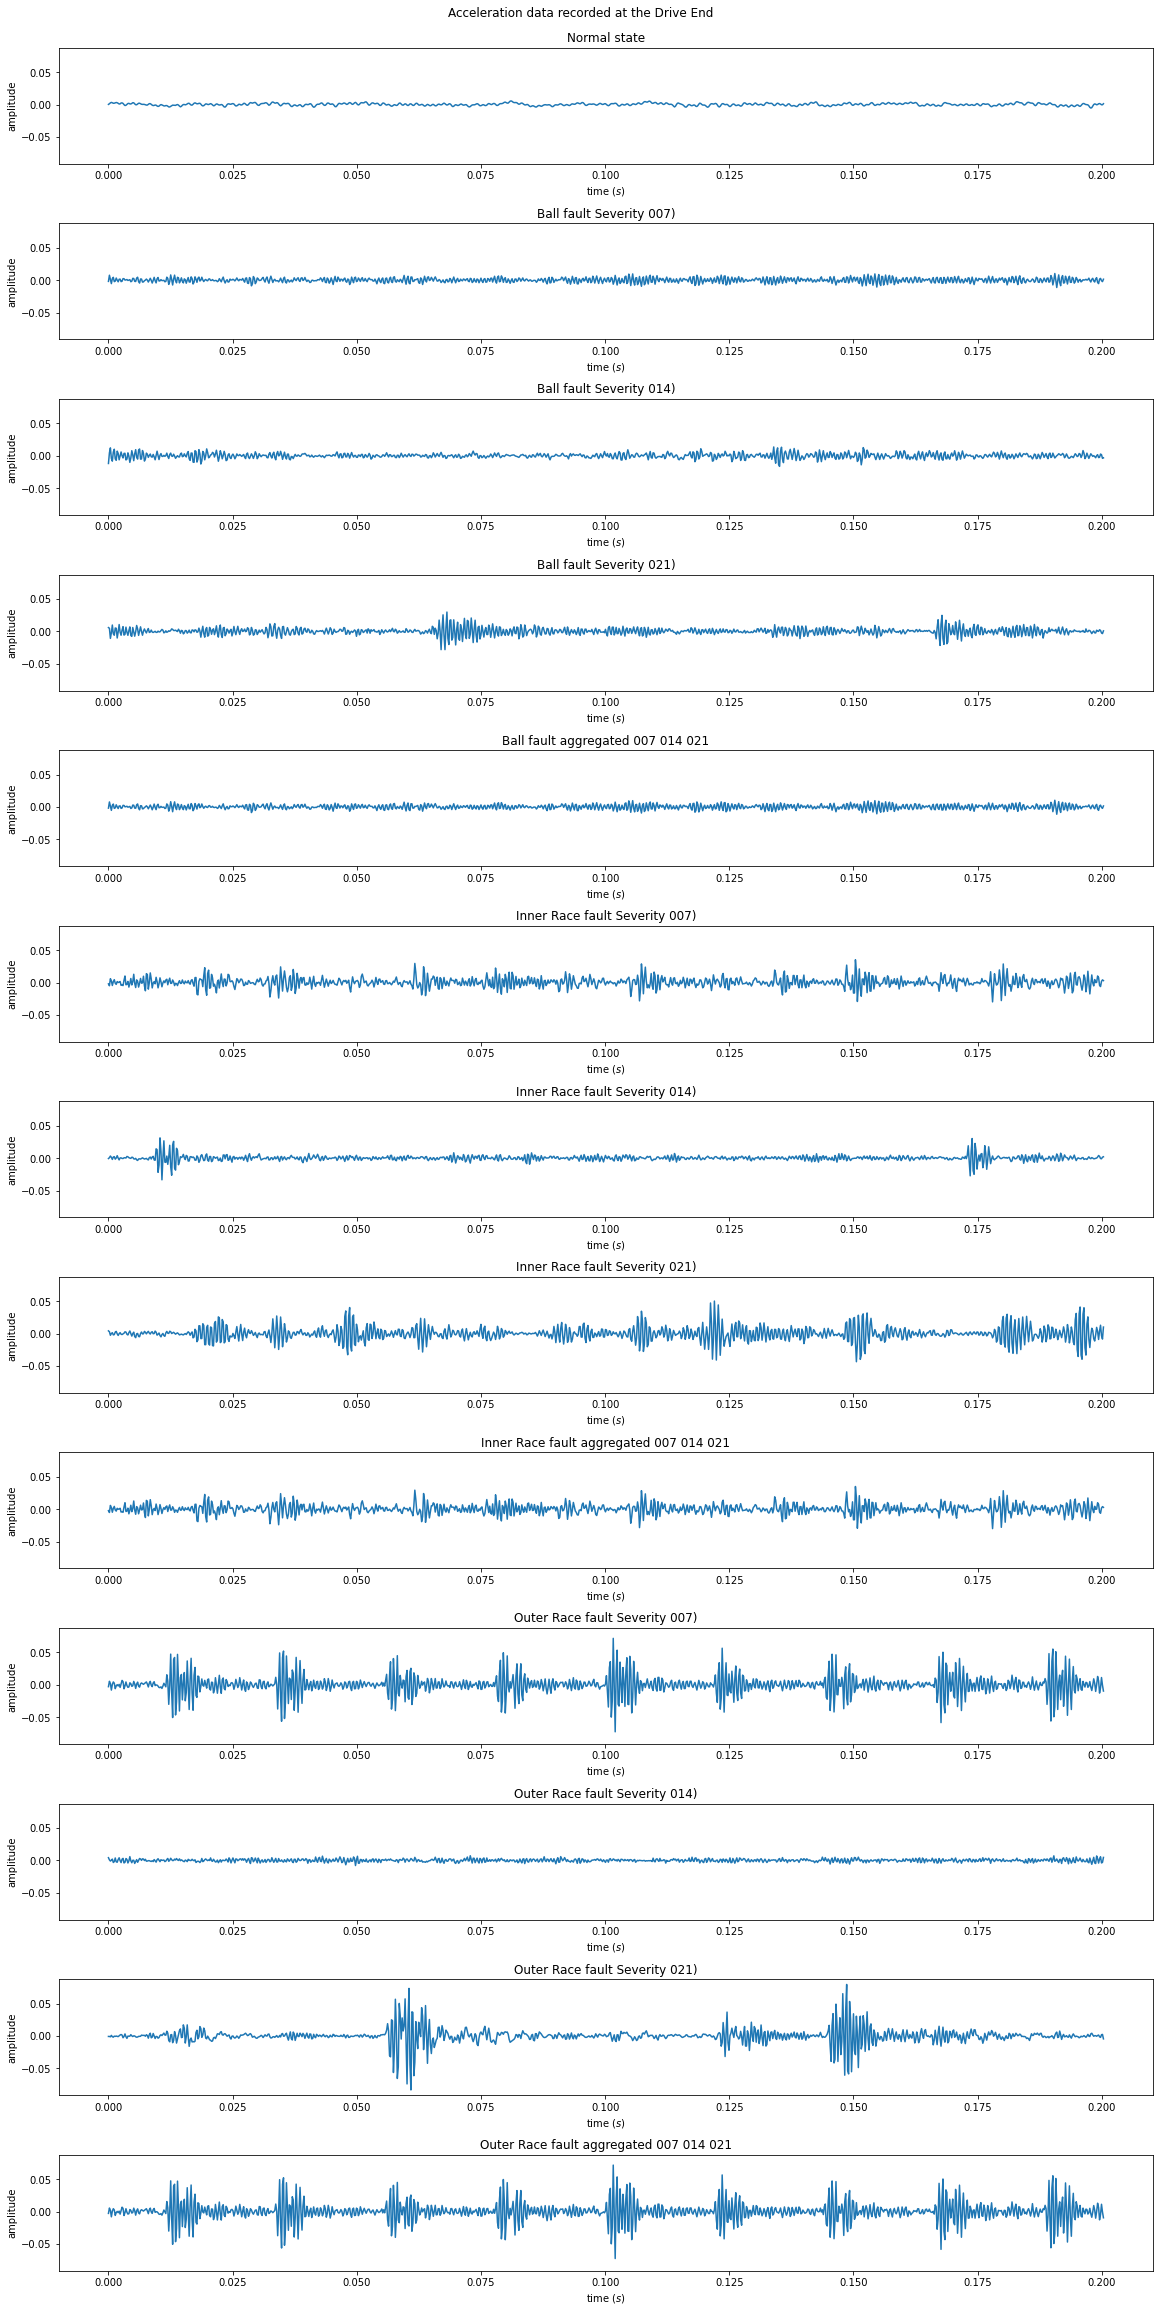

In [ ]:
#@title Default title text
%matplotlib inline

range_of_samples = np.arange(0,1024)

# fs is sampling Rate = 12k
fs = 12000
duration = 1
N = int(duration * fs)
N = np.arange(N)
# t = np.arange(N)/fs

# plotting
fig, axs = plt.subplots(13, 1, sharey=True, figsize=(16, 32), constrained_layout=True)
fig.suptitle('Acceleration data recorded at the Drive End')

axs[0].plot(range_of_samples/fs * 2.35, G_data_N_DE[range_of_samples])
axs[0].set_title('Normal state')

axs[1].plot(range_of_samples/fs * 2.35, G_data_B_007_DE[range_of_samples])
axs[1].set_title('Ball fault Severity 007)')

axs[2].plot(range_of_samples/fs * 2.35, G_data_B_014_DE[range_of_samples])
axs[2].set_title('Ball fault Severity 014)')

axs[3].plot(range_of_samples/fs * 2.35, G_data_B_021_DE[range_of_samples])
axs[3].set_title('Ball fault Severity 021)')

axs[4].plot(range_of_samples/fs * 2.35, G_data_B_DE[range_of_samples])
axs[4].set_title('Ball fault aggregated 007 014 021')

axs[5].plot(range_of_samples/fs * 2.35, G_data_IR_007_DE[range_of_samples])
axs[5].set_title('Inner Race fault Severity 007)')

axs[6].plot(range_of_samples/fs * 2.35, G_data_IR_014_DE[range_of_samples])
axs[6].set_title('Inner Race fault Severity 014)')

axs[7].plot(range_of_samples/fs * 2.35, G_data_IR_021_DE[range_of_samples])
axs[7].set_title('Inner Race fault Severity 021)')

axs[8].plot(range_of_samples/fs * 2.35, G_data_IR_DE[range_of_samples])
axs[8].set_title('Inner Race fault aggregated 007 014 021')

axs[9].plot(range_of_samples/fs * 2.35, G_data_OR_007_DE[range_of_samples])
axs[9].set_title('Outer Race fault Severity 007)')

axs[10].plot(range_of_samples/fs * 2.35, G_data_OR_014_DE[range_of_samples])
axs[10].set_title('Outer Race fault Severity 014)')

axs[11].plot(range_of_samples/fs * 2.35, G_data_OR_021_DE[range_of_samples])
axs[11].set_title('Outer Race fault Severity 021)')

axs[12].plot(range_of_samples/fs * 2.35, G_data_OR_DE[range_of_samples])
axs[12].set_title('Outer Race fault aggregated 007 014 021')

for ax in axs.flat:
    ax.set(xlabel='time $(s)$', ylabel='amplitude')

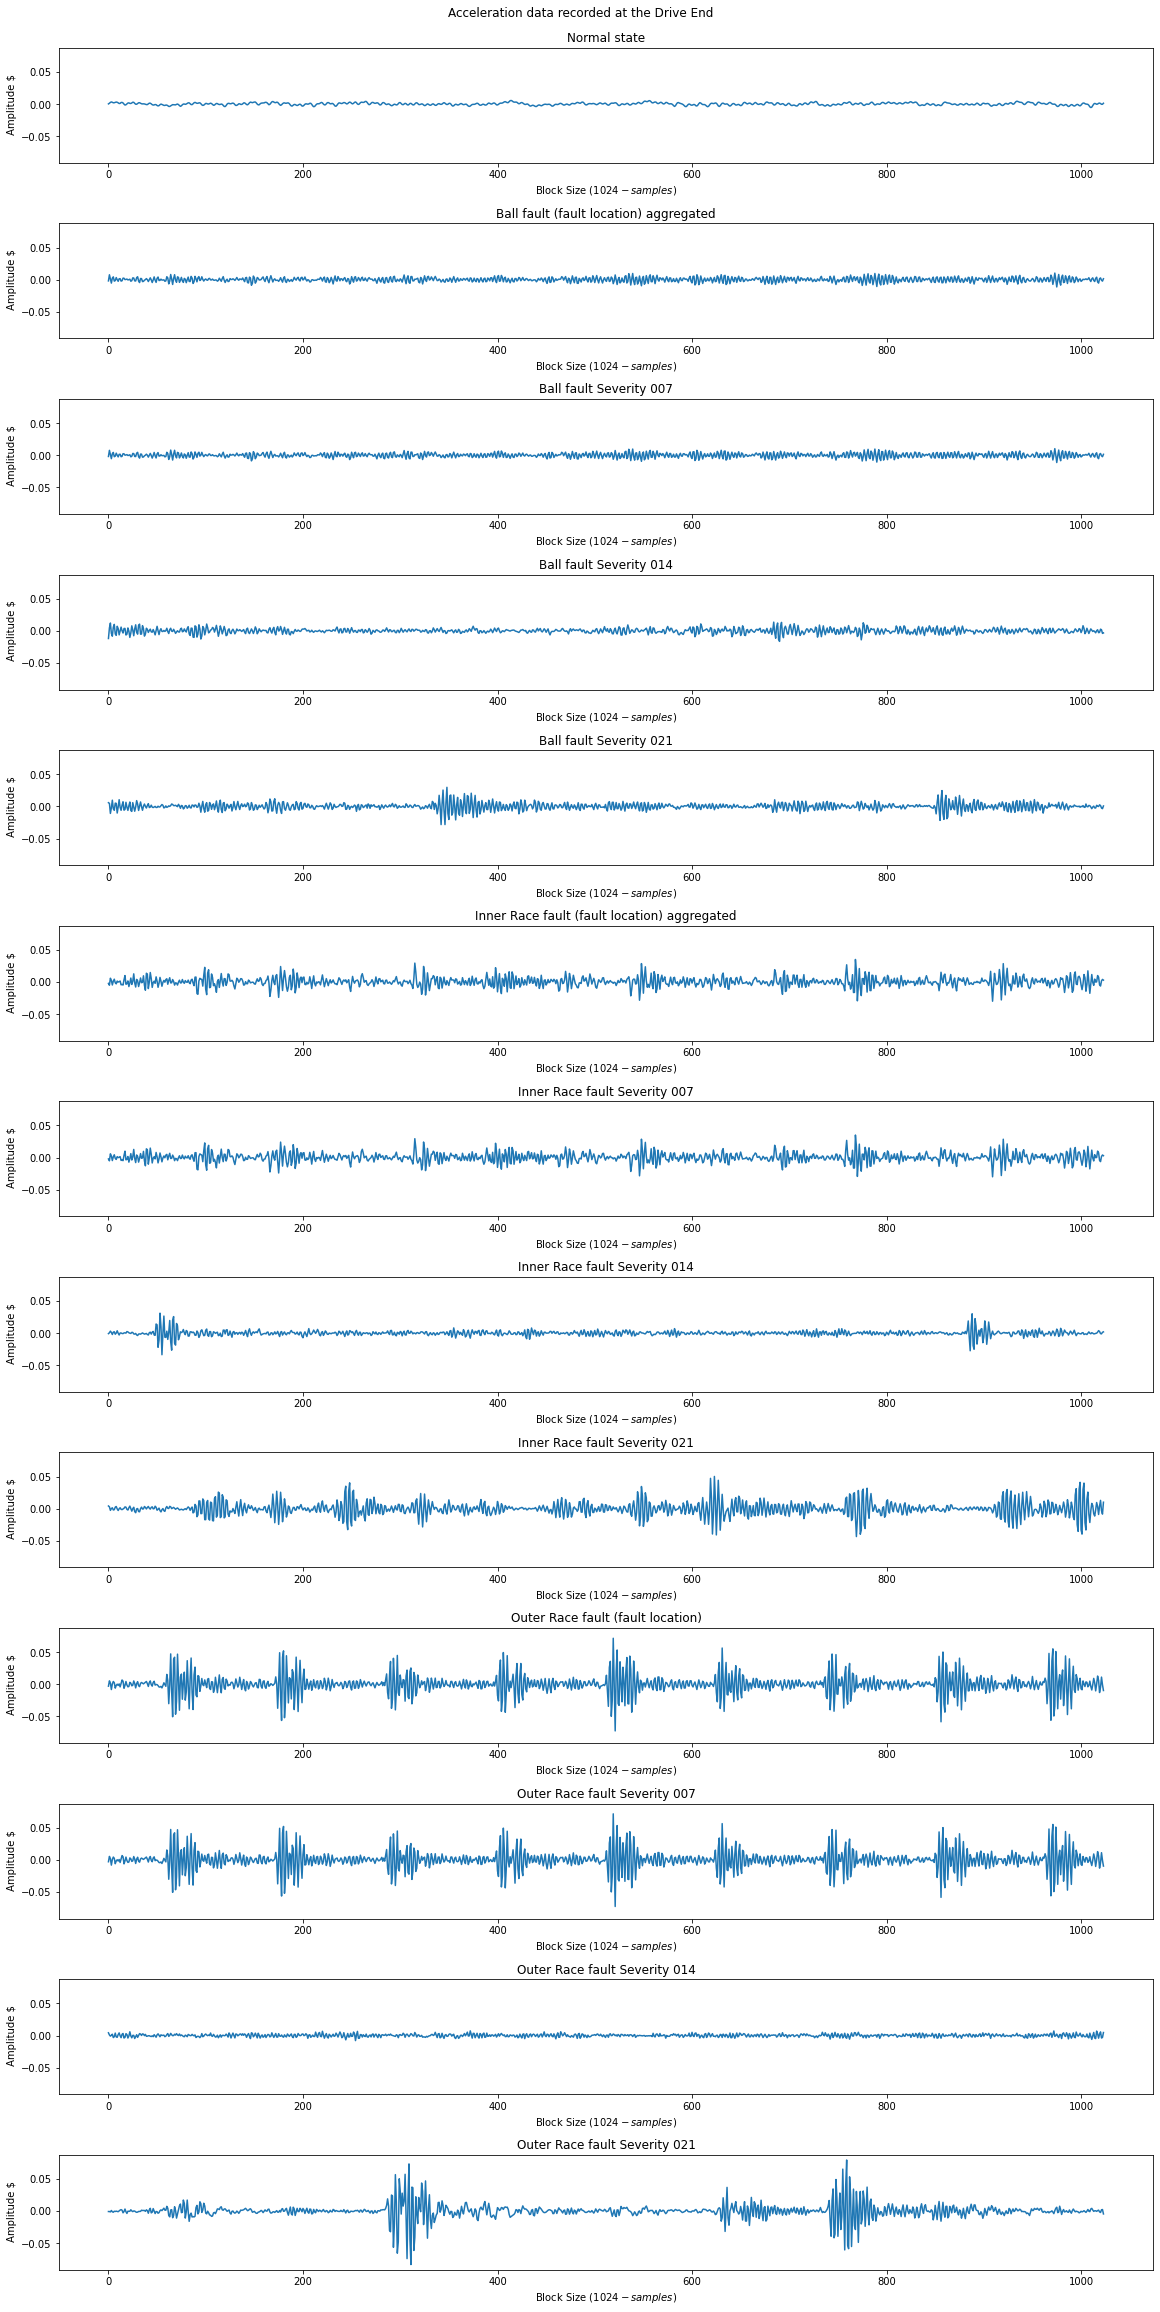

In [ ]:
#@title Default title text
%matplotlib inline

# range_of_samples = np.arange(0,1024)
range_of_samples = np.arange(0,1024)
fs = 12000

# plotting
fig, axs = plt.subplots(13, 1, sharey=True, figsize=(16, 32), constrained_layout=True)
fig.suptitle('Acceleration data recorded at the Drive End')

axs[0].plot(G_data_N_DE[range_of_samples])
axs[0].set_title('Normal state')

axs[1].plot(G_data_B_DE[range_of_samples])
axs[1].set_title('Ball fault (fault location) aggregated')

axs[2].plot(G_data_B_007_DE[range_of_samples])
axs[2].set_title('Ball fault Severity 007')

axs[3].plot(G_data_B_014_DE[range_of_samples])
axs[3].set_title('Ball fault Severity 014')

axs[4].plot(G_data_B_021_DE[range_of_samples])
axs[4].set_title('Ball fault Severity 021')

axs[5].plot(G_data_IR_DE[range_of_samples])
axs[5].set_title('Inner Race fault (fault location) aggregated')

axs[6].plot(G_data_IR_007_DE[range_of_samples])
axs[6].set_title('Inner Race fault Severity 007')

axs[7].plot(G_data_IR_014_DE[range_of_samples])
axs[7].set_title('Inner Race fault Severity 014')

axs[8].plot(G_data_IR_021_DE[range_of_samples])
axs[8].set_title('Inner Race fault Severity 021')

axs[9].plot(G_data_OR_DE[range_of_samples])
axs[9].set_title('Outer Race fault (fault location)')

axs[10].plot(G_data_OR_007_DE[range_of_samples])
axs[10].set_title('Outer Race fault Severity 007')

axs[11].plot(G_data_OR_014_DE[range_of_samples])
axs[11].set_title('Outer Race fault Severity 014')

axs[12].plot(G_data_OR_021_DE[range_of_samples])
axs[12].set_title('Outer Race fault Severity 021')

for ax in axs.flat:
    ax.set(xlabel='Block Size $(1024-samples)$', ylabel=' Amplitude $')

* upon running the code snippet above, you’ll obtain a visual representation of the signal, notice how the Block size (N) which 1024, the total number of time data points that are captured to perform a Fourier Transform, whereas SR is 12khz which’s is the number of data points acquired per second.

# 4. Preprocessing of Vibrational Signal

## Preprocessing Steps

1. Signal Data split into fixed-cycle of 5 seconds

2. STFT is applied on each signal segment

3. Spectrogram Image creating

4. Image Analysis

5. Image loading

6. Data shuffling

7. Convolutional Neural Network (CNN) or Transfer Learning

## 4.1 Vibration Signal to be splited into fixed Cycle
I've used some information from this link to split the signal into fixed cycle of 5 seconds, Please refer to this link for more information:
https://www.audiolabs-erlangen.de/resources/MIR/FMP/C2/C2_STFT-Basic.html




In [ ]:
def split_sig_fixed_5s_cycle(sig, split_by_sec):
    L = len(sig)          # length of the signal
    num_5s_splits = L // split_by_sec
    last = num_5s_splits * split_by_sec
    x_new = sig[:last]
    x_new = np.array_split(x_new, split_by_sec)
    x_new = np.array(x_new)
    print(f'Signal name {namestr(sig, globals())}, Signal Original shape: {sig.shape} The output Shape: {x_new.shape}')
    return x_new

def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

In [ ]:
Fs = 12000                # sampling frequency 

# Level #1
G_data_N_DE_1     =     split_sig_fixed_5s_cycle(G_data_N_DE, Fs)
G_data_faulty_DE_1     =     split_sig_fixed_5s_cycle(G_data_faulty, Fs)

# Level #2
# G_data_N_DE_1     =     split_sig_fixed_5s_cycle(G_data_N_DE, Fs)
G_data_B_DE_1     =     split_sig_fixed_5s_cycle(G_data_B_DE, Fs)
G_data_IR_DE_1     =     split_sig_fixed_5s_cycle(G_data_IR_DE, Fs)
G_data_OR_DE_1     =     split_sig_fixed_5s_cycle(G_data_OR_DE, Fs)

# Level #3
# G_data_N_DE_1     =     split_sig_fixed_5s_cycle(G_data_N_DE, t)
G_data_B_007_DE_1 = split_sig_fixed_5s_cycle(G_data_B_007_DE, Fs)
G_data_B_014_DE_1 = split_sig_fixed_5s_cycle(G_data_B_021_DE, Fs)
G_data_B_021_DE_1 = split_sig_fixed_5s_cycle(G_data_B_021_DE, Fs)

G_data_IR_007_DE_1 = split_sig_fixed_5s_cycle(G_data_IR_007_DE, Fs)
G_data_IR_014_DE_1 = split_sig_fixed_5s_cycle(G_data_IR_014_DE, Fs)
G_data_IR_021_DE_1 = split_sig_fixed_5s_cycle(G_data_IR_021_DE, Fs)

G_data_OR_007_DE_1 = split_sig_fixed_5s_cycle(G_data_OR_007_DE, Fs)
G_data_OR_014_DE_1 = split_sig_fixed_5s_cycle(G_data_OR_014_DE, Fs)
G_data_OR_021_DE_1 = split_sig_fixed_5s_cycle(G_data_OR_021_DE, Fs)

Signal name ['G_data_N_DE'], Signal Original shape: (1698547,) The output Shape: (12000, 141)
Signal name ['G_data_faulty'], Signal Original shape: (6344600,) The output Shape: (12000, 528)
Signal name ['G_data_B_DE'], Signal Original shape: (1463166,) The output Shape: (12000, 121)
Signal name ['G_data_IR_DE'], Signal Original shape: (1463077,) The output Shape: (12000, 121)
Signal name ['G_data_OR_DE'], Signal Original shape: (3418357,) The output Shape: (12000, 284)
Signal name ['G_data_B_007_DE'], Signal Original shape: (487093,) The output Shape: (12000, 40)
Signal name ['G_data_B_021_DE'], Signal Original shape: (487964,) The output Shape: (12000, 40)
Signal name ['G_data_B_021_DE'], Signal Original shape: (487964,) The output Shape: (12000, 40)
Signal name ['G_data_IR_007_DE'], Signal Original shape: (488309,) The output Shape: (12000, 40)
Signal name ['G_data_IR_014_DE'], Signal Original shape: (487239,) The output Shape: (12000, 40)
Signal name ['G_data_IR_021_DE'], Signal Ori

## 4.1.1 Missing Time Localization, `This is just an example, you can skip`
This section contain an example of how STFT is applied, please visit :https://www.audiolabs-erlangen.de/resources/MIR/FMP/C2/C2_STFT-Basic.html

The Fourier transform yields frequency information that is averaged over the entire time domain. However, the information on when these frequencies occur is hidden in the transform. This phenomenon is illustrated by the following example.

/usr/local/lib/python3.7/dist-packages/resampy/interpn.py:114: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  _resample_loop_p(x, t_out, interp_win, interp_delta, num_table, scale, y)


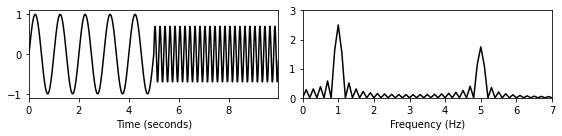

In [ ]:
from  matplotlib import pyplot as plt
import librosa
from ipywidgets import interact, fixed, FloatSlider
import IPython.display as ipd
%matplotlib inline

Fs = 128
duration = 10
omega1 = 1
omega2 = 5
N = int(duration * Fs)
t = np.arange(N) / Fs
t1 = t[:N//2]
t2 = t[N//2:]

x1 = 1.0 * np.sin(2 * np.pi * omega1 * t1)
x2 = 0.7 * np.sin(2 * np.pi * omega2 * t2)
x = np.concatenate((x1, x2))

plt.figure(figsize=(8, 2))
plt.subplot(1, 2, 1)
plt.plot(t, x, c='k')
plt.xlim([min(t), max(t)])
plt.xlabel('Time (seconds)')

plt.subplot(1, 2, 2)
X = np.abs(np.fft.fft(x)) / Fs
freq = np.fft.fftfreq(N, d=1/Fs)
X = X[:N//2]
freq = freq[:N//2]
plt.plot(freq, X, c='k')
plt.xlim([0, 7])
plt.ylim([0, 3])
plt.xlabel('Frequency (Hz)')
plt.tight_layout()

### 4.1.2 Basic Idea, `You can skip this as well`
To recover the hidden time information, Dennis Gabor introduced in the year 1946 the short-time Fourier transform (STFT). 
Instead of considering the entire signal, the main idea of the STFT is to consider only a small section of the signal. To this end, one fixes a so-called window function, which is a function that is nonzero for only a short period of time (defining the considered section). 
The original signal is then multiplied with the window function to yield a windowed signal. To obtain frequency information at different time instances, one shifts the window function across time and computes a Fourier transform for each of the resulting windowed signals. This idea is illustrated by the next example.

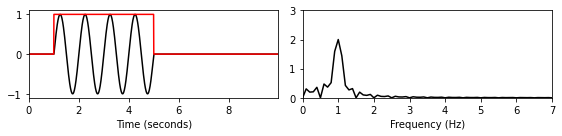

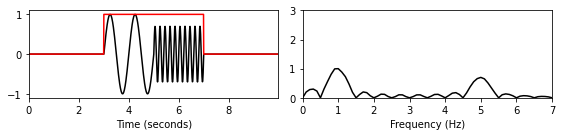

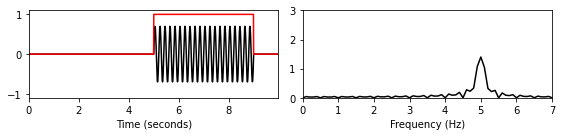

Interactive interface for experimenting with different window shifts:


interactive(children=(FloatSlider(value=1.7, continuous_update=False, description='Position', max=6.0), Output…

In [ ]:
def windowed_ft(t, x, Fs, w_pos_sec, w_len):
    
    N = len(x)
    w_pos = int(Fs * w_pos_sec)
    w_padded = np.zeros(N)
    w_padded[w_pos:w_pos + w_len] = 1
    x = x * w_padded    
    plt.figure(figsize=(8, 2))

    plt.subplot(1, 2, 1)
    plt.plot(t, x, c='k')
    plt.plot(t, w_padded, c='r')
    plt.xlim([min(t), max(t)])
    plt.ylim([-1.1, 1.1])
    plt.xlabel('Time (seconds)')

    plt.subplot(1, 2, 2)
    X = np.abs(np.fft.fft(x)) / Fs
    freq = np.fft.fftfreq(N, d=1/Fs)
    X = X[:N//2]
    freq = freq[:N//2]
    plt.plot(freq, X, c='k')
    plt.xlim([0, 7])
    plt.ylim([0, 3])
    plt.xlabel('Frequency (Hz)')
    plt.tight_layout()
    plt.show()
    
w_len = 4 * Fs
windowed_ft(t, x, Fs, w_pos_sec=1, w_len=w_len)
windowed_ft(t, x, Fs, w_pos_sec=3, w_len=w_len)
windowed_ft(t, x, Fs, w_pos_sec=5, w_len=w_len)

print('Interactive interface for experimenting with different window shifts:')
interact(windowed_ft,
         w_pos_sec=FloatSlider(min=0, max=duration-(w_len/Fs), step=0.1, 
                continuous_update=False, value=1.7, description='Position'),
                t=fixed(t), x=fixed(x), Fs=fixed(Fs), w_len=fixed(w_len));

### 4.1.3 Window Function effect on Bearing Nominal Vibration Signal 

The Nominal Bearing Status `G_data_N_DE` is then multiplied with the window function to yield a windowed signal. To obtain `frequency information at different time instances`, one shifts the window function across time and `computes a Fourier transform for each of the resulting windowed signals`. This idea is illustrated by the next example.

In [ ]:
def windowed_ft(t, x, Fs, duration, w_pos_sec, w_len):

    bs = np.arange(int(duration * Fs))  # Block_size which we'll use to split the signal, long signal will be sliced by the length of block_size = bs = 40s, This is hyparameter
    N = len(x[bs])                      # Divide signal length which will be 5 seconds taken off the entire vibration signal
    w_pos = int(Fs * w_pos_sec)         # this the window position, if w_pos = 0, this means the window will start from the begenning of the signal, 
                                        # if w_pos = 1 the window will start from the first seconds of the sliced signal

    w_padded = np.zeros(N)              # Replicate the length of the signal but the signal data will be zero-ed but the length will be equal to N
    w_padded[w_pos:w_pos + w_len] = 1   # here the padding or shifting mechansim happen, so [from w_pos=0s of the signal: to w_pos=0 + window_length=5s]  [0 to 5s] = 1
                                        # and we equate that with 1, which mean this 5s will be equal to 1 value, whereas the rest will be zero
                                        # This mean that we will ensure that we capture the first 5 seconds do so by sliding the window
     
    Window_x = x[bs] * w_padded                # we then multiply the 40s signal * "[40s signal]" note that the quoted 40s, has only 5s of it has the value of 1 and the rest 
                                        # has the value of zero 
    T = np.arange(0, 1024) / Fs
                                        
    #  plotting                                  
    plt.figure(figsize=(16, 2))
    plt.subplot(1, 3, 3)
    plt.plot(x[bs], c='Green')
    plt.ylim([-0.1, 0.1])

    plt.subplot(1, 3, 1)
    plt.plot(t, Window_x, c='Green')
    plt.plot(t, w_padded, c='Red')
    plt.xlim([min(t), max(t)])
    plt.ylim([-0.1, 0.1])
    plt.xlabel('Time (seconds)')

    plt.subplot(1, 3, 2)
    X = np.abs(np.fft.fft(Window_x)) / Fs
    freq = np.fft.fftfreq(N, d=1/Fs)
    X = X[:N//2]
    freq = freq[:N//2]
    plt.plot(freq, X, c='Blue')
    plt.xlim([-1000, 8000])
    plt.ylim([-0.0050, 0.0050])
    plt.xlabel('Frequency (Hz)')
    plt.tight_layout()
    plt.show()

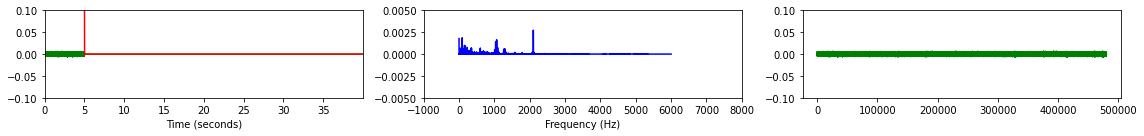

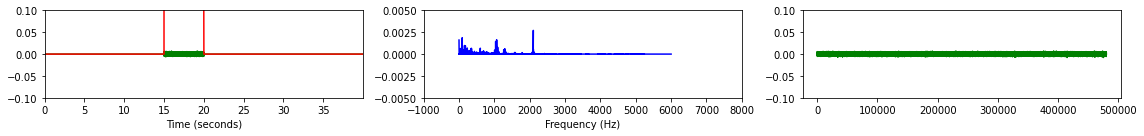

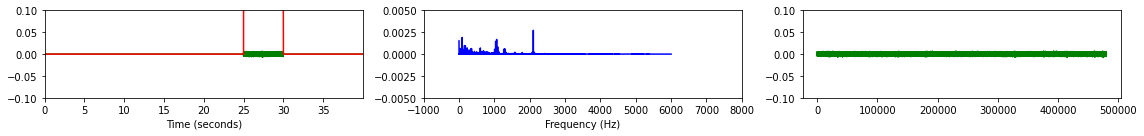

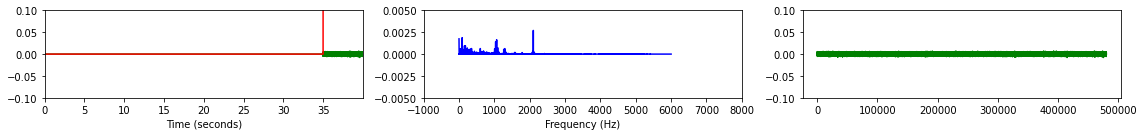

Interactive interface for experimenting with different window shifts:


interactive(children=(FloatSlider(value=1.7, continuous_update=False, description='Position', max=35.0, step=1…

<function __main__.windowed_ft(t, x, Fs, duration, w_pos_sec, w_len)>

In [ ]:
from IPython.core.pylabtools import figsize
# Plot Nominal Bearing Status 
x = G_data_N_DE # 1-D Signal
Fs = 12000  # Sampling frequency
w_len = 5 * Fs # window length of 5 seconds
duration = 40  # Duration of interest in seconds
bs = int(duration * Fs)   
t = np.arange(bs) / Fs   # t which's the amounts to  Bs/Fs  seconds.
g = np.arange(int(duration * Fs))

windowed_ft(t, x, Fs, duration, w_pos_sec=0, w_len=w_len)
windowed_ft(t, x, Fs, duration, w_pos_sec=15, w_len=w_len)
windowed_ft(t, x, Fs, duration, w_pos_sec=25, w_len=w_len)
windowed_ft(t, x, Fs, duration, w_pos_sec=35, w_len=w_len)

print('Interactive interface for experimenting with different window shifts:')
interact(windowed_ft, figsize=(16, 6), w_pos_sec=FloatSlider(min=0, max=duration-(w_len/Fs), step=1, 
                continuous_update=False, value=1.7, description='Position'),
                t=fixed(t), x=fixed(x[g]), duration=fixed(duration) ,Fs=fixed(Fs), w_len=fixed(w_len))

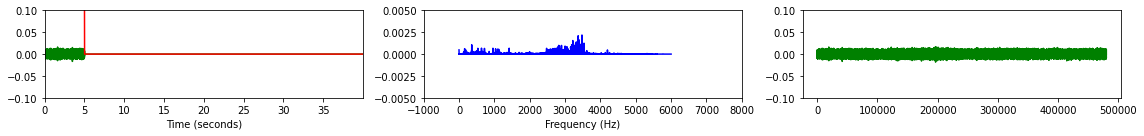

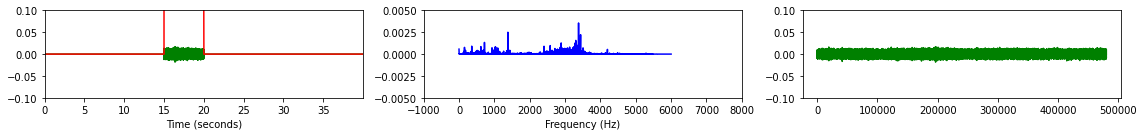

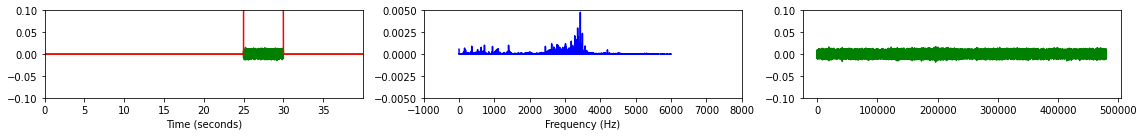

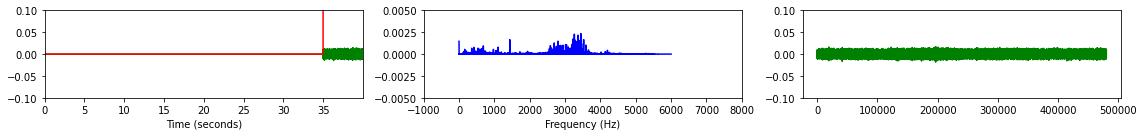

Interactive interface for experimenting with different window shifts:


interactive(children=(FloatSlider(value=1.7, continuous_update=False, description='Position', max=35.0, step=1…

<function __main__.windowed_ft(t, x, Fs, duration, w_pos_sec, w_len)>

In [ ]:
from IPython.core.pylabtools import figsize
# Plot Faulty Bearing Status 
x = G_data_faulty  # 1-D Signal
Fs = 12000  # Sampling frequency
w_len = 5 * Fs # window length of 5 seconds
duration = 40  # Duration of interest in seconds
bs = int(duration * Fs)   
t = np.arange(bs) / Fs   # t which's the amounts to  Bs/Fs  seconds.
g = np.arange(int(duration * Fs))

windowed_ft(t, x, Fs, duration, w_pos_sec=0, w_len=w_len)
windowed_ft(t, x, Fs, duration, w_pos_sec=15, w_len=w_len)
windowed_ft(t, x, Fs, duration, w_pos_sec=25, w_len=w_len)
windowed_ft(t, x, Fs, duration, w_pos_sec=35, w_len=w_len)

print('Interactive interface for experimenting with different window shifts:')
interact(windowed_ft, figsize=(16, 6), w_pos_sec=FloatSlider(min=0, max=duration-(w_len/Fs), step=1, 
                continuous_update=False, value=1.7, description='Position'),
                t=fixed(t), x=fixed(x[g]), duration=fixed(duration) ,Fs=fixed(Fs), w_len=fixed(w_len))

In [ ]:
def windowed_function_plot(t, sig, l_seg_sig_s, Fs, w_pos_sec, w_len):

    Seg_sig = np.arange(int(l_seg_sig_s * Fs))  # the signal will be sliced in terms of seconds using chunksize 

    L = len(sig[Seg_sig])  #-------------------# length of the entire signal x , and it's being sliced by chunksize

    w_pos = int(Fs * w_pos_sec)  #--------------# window pos which is defined in terms of seconds i.e. the starting w_pos could 0 seconds

    w_padded = np.zeros(L)   #------------------#  we replicate the length but with zeros 

    w_padded[w_pos:w_pos + w_len] = 1  #--------# here we have our slicing brackets [from 0 : to 0 + window_length] and that will be equal to 1 meaning it has a value

    x = sig[Seg_sig] * w_padded  #-------------# then multiply chunked signal by 1, when you multiply notice that the part of the signal that is being multiply with 0 will be canceled
                                  #-------------# and the part being multiplied with one will remain
    print(f'x.shape : {x.shape}')


    return x, w_padded #  return only the windowed signal 

x.shape : (480000,)


Text(0.5, 0, 'Time (seconds)')

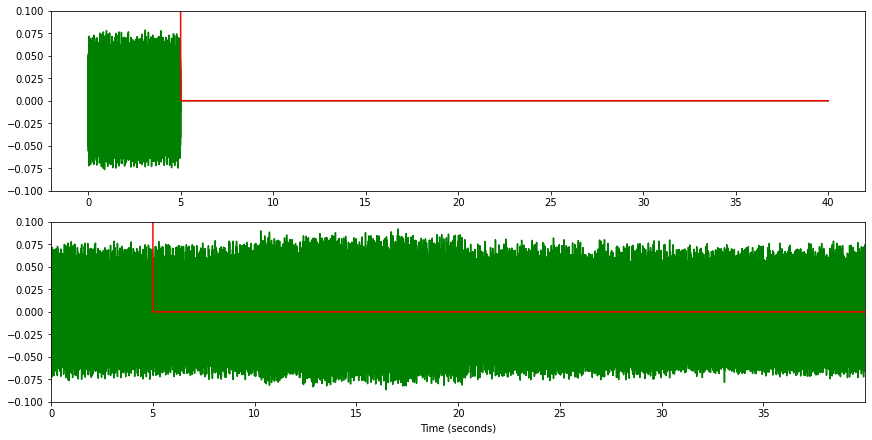

In [ ]:
X = G_data_OR_007_DE  # 1-D Signal
Fs = 12000  # Sampling frequency
w_len = 5 * Fs # window length of 5 seconds
duration = 40  # Duration in seconds
N = int(duration * Fs)  # (N) is the total number of time data points that are captured to perform a Fourier transform. 
t = np.arange(N) / Fs   # t which's the amounts to  N/Fs  seconds.
g = np.arange(0, N)
w_pos_sec = 0

x, w_padded = windowed_function_plot(t, X, duration, Fs, w_pos_sec, w_len)

# plotting
fig, axs = plt.subplots(2, 1, sharey=True, figsize=(12, 6), constrained_layout=True)


axs[0].plot(t, x[g], c='Green')
axs[0].plot(t, w_padded, c='Red')
plt.xlim([min(t), max(t)])
plt.ylim([-0.1, 0.1])
plt.xlabel('Time (seconds)')

axs[1].plot(t, X[g], c='Green')
axs[1].plot(t, w_padded, c='Red')
plt.xlim([min(t), max(t)])
plt.ylim([-0.1, 0.1])
plt.xlabel('Time (seconds)')

### 4.2 STFT Algorithm:

`Short Time Fourier Transform using Python and Numpy`
`Posted on December 13, 2014 by kevinnelsonj`

So, we understand what we’re trying to make – now we have to figure out how to make it.  The data flow we have to achieve is pretty simple, as we only need to do the following steps:

1. Pick out a short segment of data from the overall signal
2. Multiply that segment against a half-cosine function
3. Pad the end of the segment with zeros
4. Take the Fourier transform of that segment and normalize it into positive and negative frequencies
5. Combine the energy from the positive and negative frequencies together, and display the one-sided spectrum
6. Scale the resulting spectrum into dB for easier viewing
7. Clip the signal to remove noise past the noise floor which we don’t care about

Step 1 – Pick segment: We need to find our current segment to process from the overall data set.  We use the concept of a ‘sliding window’ to help us visualize what’s happening.  The data inside the window is the current segment to be processed.

The window’s length remains the same during the processing of the data, but the offset changes with each step of the algorithm.  Usually when processing the STFT, the change in offset will be less than one window length, meaning that the last window and the current window overlap.  If we define the window size, and the percentage of overlap, we know all the information we need about how the window moves throughout the processing.

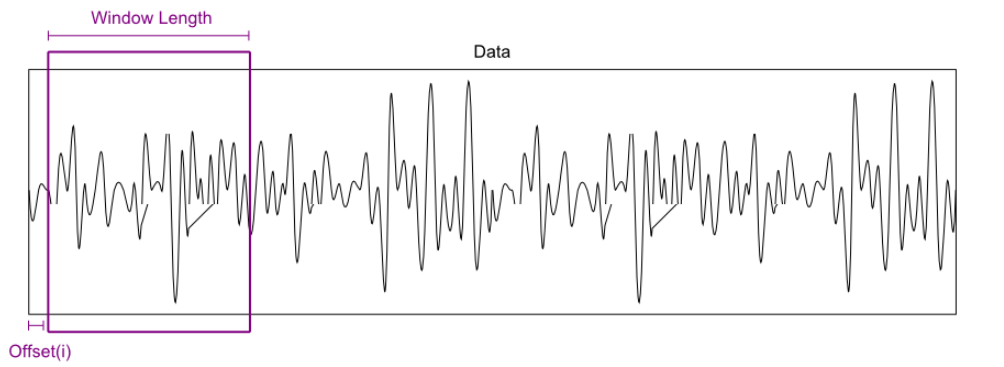

Step 2 – Multiply by half-cosine: This helps to alleviate a problem created by segmenting the data.  When the data is cut into pieces, the edges make a sharp transition that didn’t exist before.  Multiplying by a half cosine function helps to fade the signal in and out so that the transitions at the edges do not affect the Fourier transform of the data.


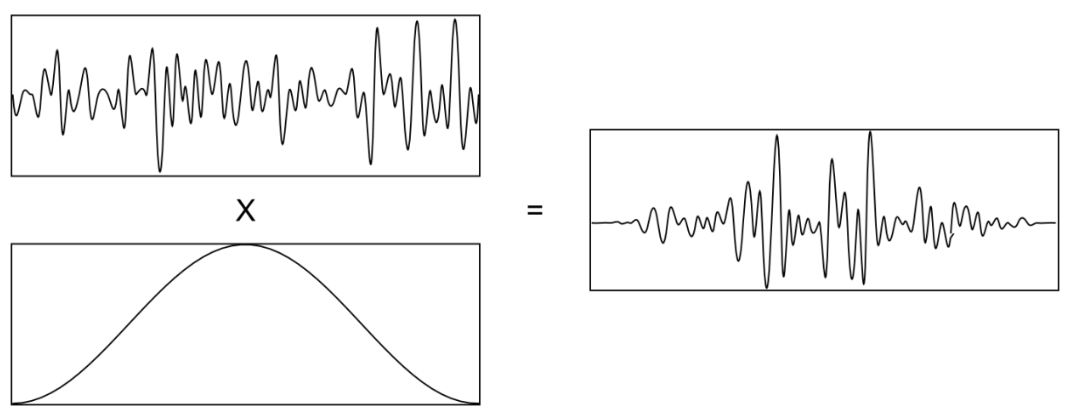

There is an additional benefit to using a half cosine window.  It can be shown that with an overlap factor of 50%, the sum of the windows is a constant value of 1.  This means that multiplying our data by this particular function does not introduce differences in amplitude from the original signal.  This is mostly important if the waveform has some type of units attached to it [pascals] and we want the frequencies in the Fourier transform to correctly represent the energy content of each frequency in those units.

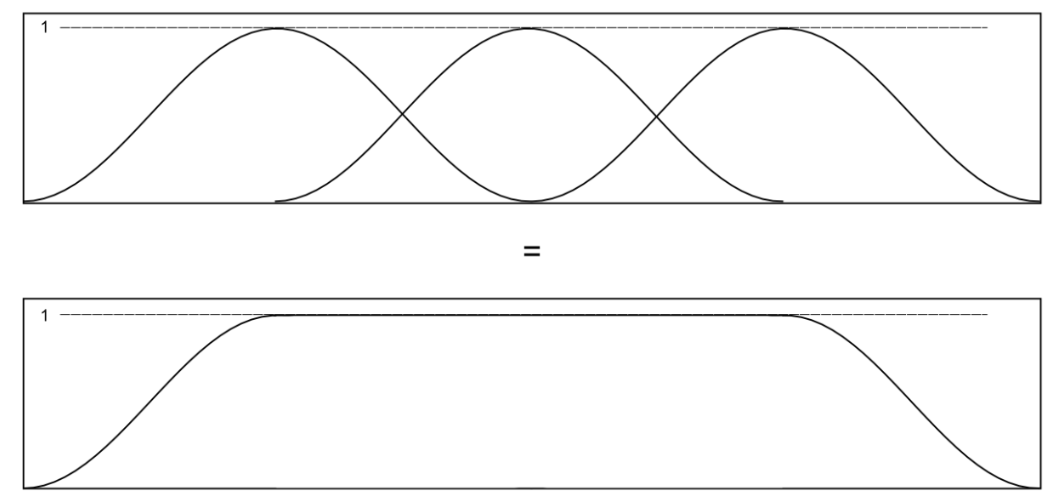

Step 3 – Pad Data: We pad the end of the current segment with a number of zeros equal to the length of the window.  Or in other words, the new segment will be twice as long as the original segment.

Step 4 – Fourier Transform and Scale: This is where all the magic happens.  Everything up to this point was just preparing the data, but this step is the beating heart of the algorithm.  Here we finally take the Fourier transform of the data.  I’m not going to explain the Fourier transform here except to say that it takes a signal and extracts the frequency content from that signal.  There are a few other things that need to be remembered about the Fourier transform.

* `The number of samples of data in is equal to the number of frequency bins out`
* The maximum frequency that can be represented is the Nyquist frequency, or `half the sampling frequency of the data`.
* In the the Discrete Fourier Transform (what we are using) the order of the frequency bins is 0 Hz (DC component), positive frequencies, Nyquist Frequency, negative frequencies
* The data from the Fourier transform needs to be scaled by the number of samples in the transform to maintain equal energy (according to Parseval’s theorem)

Step 5 – Autopower: This is just more post processing to make the results more palatable to look at.  We find the autopower spectrum from the results of the Fourier transform.  The autopower spectrum is a one-sided spectrum (only contains positive frequencies) as opposed to the two-sided spectrum returned by the Fourier transform – so it’s more like the actual real world which does not contain negative frequencies.  The autopower spectrum is also scaled to represent the energy content that was in both the positive and negative frequencies of the Fourier transform.  This is important for the ‘correctness’ of the energy content of each frequency, but also has the handy benefit of suppressing lower energy content and dramatizing higher energy content.  Usually people only care about the higher energy content, so finding this transform typically makes the data much easier to look at.

Part of taking the autopwer spectrum is throwing away the upper half of the array of data.  This is why we padded the segment to twice it’s size – so that when the result was cut down by half by the autopower transform, we would still have the same number of frequency bins as samples in our segment.  Note that this isn’t a strict requirement of the algorithm – to have the segment size as frequency bins.  We could have chosen our pad length to be any number from zero (no padding) to infinity.  There is a trade off here which is too heavy in theory to go into fully here, suffice to say that I found this decision works well and simplifies the math.

Step 6 – Convert to DB: This is another transform to make the data easier to look at.  It turns out that peoples ears work on a logarithmic scale so that the ear can detect much finer changes in amplitude at low amplitudes than at high amplitudes.  We transform the data into decibels (dB) which is a logarithmic scale, so that we can see the energy content of a signal more how our ears would detect it.  Converting the data to decibels has the effect of stretching peaks downwards towards the average sound level, and bringing troughs upwards.  This allows us to compare content at all amplitude levels.  If we didn’t do this and we scaled the data so that the peaks were visible, it would be impossible to see any shape in the quieter values, vs if we looked at the quieter values, the peaks would explode off the top of the screen.

Step 7 – Clip Data: This also makes the data easier to look at.  We know from experience that everything below -40 dB is well below the noise floor and is probably just numerical error in the algorithm.  Therefore, we can clip the data so that everything below -40 dB is set to -40 dB exactly.  This gives us more color range to apply to significant portions of our data.

## 4.3 Creating Spectrogram images via `libfmp.c2.stft_convention_fmp`



In [ ]:
from skimage.transform import resize
import librosa, librosa.display
import libfmp.c2

def stft_on_1s_window(sig, w_len, sr=12000, overlapFac=0.25):

    N = w_len
    HopSize = int(np.floor(overlapFac * N))
    Fs = 12000

    if sig.ndim == 1:
       # print(f"signal has one dimension {sig.shape}")
       X, T_coef, F_coef = libfmp.c2.stft_convention_fmp(sig, Fs, w_len, HopSize)
       Y = np.abs(X) ** 2
       Y = np.array(Y)
    
    return Y, T_coef, F_coef

# for now Ignor this Normalization function
def min_max_norm(ary):
    ary = (ary - ary.min()) / np.abs(ary.max() - ary.min())
    return ary

Plot few images of different ball bearing working condition 

input data shape (12000, 141)
After reshape input data shape (141, 12000)
Shape of spectrogram (513, 47)
Shape of spectrogram (513, 47)
Shape of spectrogram (513, 47)
Shape of spectrogram (513, 47)
input data shape (12000, 528)
After reshape input data shape (528, 12000)
Shape of spectrogram (513, 47)
Shape of spectrogram (513, 47)
Shape of spectrogram (513, 47)
Shape of spectrogram (513, 47)


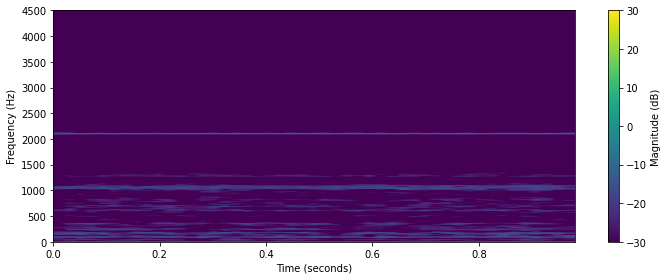

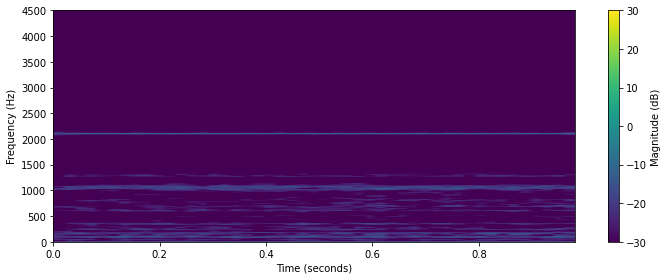

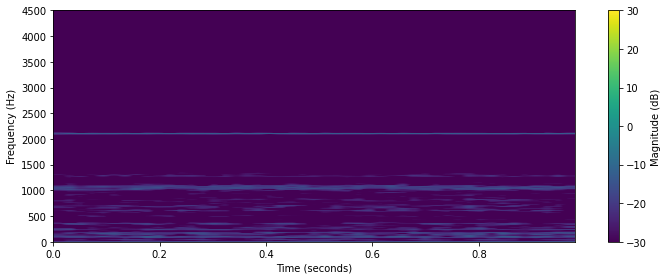

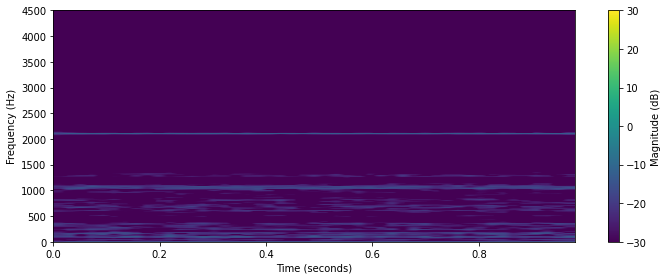

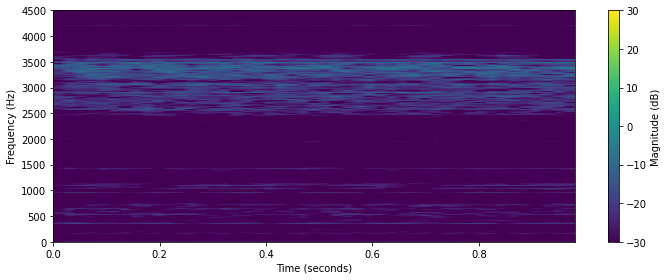

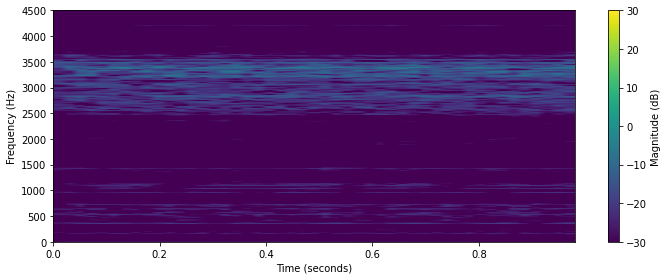

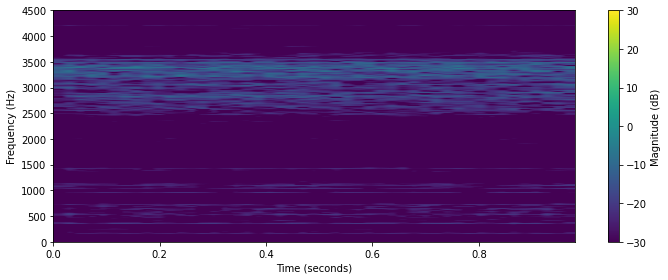

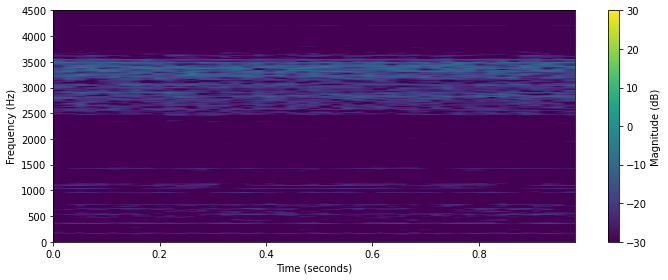

In [ ]:
list_of_data_types = [G_data_N_DE_1, G_data_faulty_DE_1]

for i in range(len(list_of_data_types)):

    print(f"input data shape", list_of_data_types[i].shape)
    sig = list_of_data_types[i]
    sig = np.reshape(sig, (sig.shape[1], sig.shape[0]))
    print(f"After reshape input data shape", sig.shape)

    samples = sig.shape[0]
    w_len = 1024
    overlapFac = 0.25
    Fs = 12000
    
    for l in range(samples):
        Y, T_coef, F_coef = stft_on_1s_window(sig[l], w_len, sr=Fs, overlapFac=overlapFac)

        # Plot spectrogram
        if l <= 3:
           print("Shape of spectrogram", Y.shape)
           fig = plt.figure(figsize=(10, 4))
           eps = np.finfo(float).eps
           plt.imshow(10 * np.log10(eps + Y), origin='lower', aspect='auto', cmap='viridis', 
                      extent=[T_coef[0], T_coef[-1], F_coef[0], F_coef[-1]])
           plt.clim([-30, 30])
           plt.ylim([0, 4500])
           plt.xlabel('Time (seconds)')
           plt.ylabel('Frequency (Hz)')
           cbar = plt.colorbar()
           cbar.set_label('Magnitude (dB)')
           plt.tight_layout()
        
        #sxx = 10 * np.log10(eps + Y)  
        #image_shape = (32, 32)
        #sxx = resize(sxx, image_shape, mode='constant', anti_aliasing=True)


del list_of_data_types

In [ ]:
def loopOver_SignalSegmentsOf5s_Spectrogram(typeOfBearingFault):
    
    # print(f"input data shape", typeOfBearingFault.shape)
    sig = typeOfBearingFault
    sig = np.reshape(sig, (sig.shape[1], sig.shape[0]))
    print(f"After reshape input data shape", sig.shape)

    samples = sig.shape[0]
    w_len = 1024
    overlapFac = 0.25
    Fs = 12000

    store = []
    for l in range(samples):
        Y, T_coef, F_coef = stft_on_1s_window(sig[l], w_len, sr=Fs, overlapFac=overlapFac)

        scaled_spc_images = 10 * np.log10(eps + Y)

        image_shape = (32,32)
        
        Square_spectrograme_images = resize(scaled_spc_images, image_shape, mode='constant', anti_aliasing=True)

        arr = min_max_norm(Square_spectrograme_images) # array to 0 - 1
        
        store.append(arr)

    store = np.array(store)

    return store

In [ ]:
G_data_N_DE_1      = loopOver_SignalSegmentsOf5s_Spectrogram(G_data_N_DE_1)
G_data_faulty_DE_1 = loopOver_SignalSegmentsOf5s_Spectrogram(G_data_faulty_DE_1)

# G_data_N_DE_1      = loopOver_SignalSegmentsOf5s_Spectrogram(G_data_N_DE_1)
G_data_B_DE_1 = loopOver_SignalSegmentsOf5s_Spectrogram(G_data_B_DE_1)
G_data_IR_DE_1 = loopOver_SignalSegmentsOf5s_Spectrogram(G_data_IR_DE_1)
G_data_OR_DE_1 = loopOver_SignalSegmentsOf5s_Spectrogram(G_data_OR_DE_1)

# G_data_N_DE_1      = loopOver_SignalSegmentsOf5s_Spectrogram(G_data_N_DE_1)
G_data_B_007_DE_1  = loopOver_SignalSegmentsOf5s_Spectrogram(G_data_B_007_DE_1)
G_data_B_014_DE_1  = loopOver_SignalSegmentsOf5s_Spectrogram(G_data_B_014_DE_1)
G_data_B_021_DE_1  = loopOver_SignalSegmentsOf5s_Spectrogram(G_data_B_021_DE_1)

G_data_IR_007_DE_1 = loopOver_SignalSegmentsOf5s_Spectrogram(G_data_IR_007_DE_1)
G_data_IR_014_DE_1 = loopOver_SignalSegmentsOf5s_Spectrogram(G_data_IR_014_DE_1)
G_data_IR_021_DE_1 = loopOver_SignalSegmentsOf5s_Spectrogram(G_data_IR_021_DE_1)

G_data_OR_007_DE_1 = loopOver_SignalSegmentsOf5s_Spectrogram(G_data_OR_007_DE_1)
G_data_OR_014_DE_1 = loopOver_SignalSegmentsOf5s_Spectrogram(G_data_OR_014_DE_1)
G_data_OR_021_DE_1 = loopOver_SignalSegmentsOf5s_Spectrogram(G_data_OR_021_DE_1)

After reshape input data shape (141, 12000)
After reshape input data shape (528, 12000)
After reshape input data shape (121, 12000)
After reshape input data shape (121, 12000)
After reshape input data shape (284, 12000)
After reshape input data shape (40, 12000)
After reshape input data shape (40, 12000)
After reshape input data shape (40, 12000)
After reshape input data shape (40, 12000)
After reshape input data shape (40, 12000)
After reshape input data shape (40, 12000)
After reshape input data shape (122, 12000)
After reshape input data shape (40, 12000)
After reshape input data shape (122, 12000)


In [ ]:
print(G_data_N_DE_1.shape)
print(G_data_faulty_DE_1.shape)

# G_data_N_DE_1   
print(G_data_B_DE_1.shape)
print(G_data_IR_DE_1.shape)
print(G_data_OR_DE_1.shape)


# G_data_N_DE_1  
print(G_data_B_007_DE_1.shape)  
print(G_data_B_014_DE_1.shape)  
print(G_data_B_021_DE_1.shape)  

print(G_data_IR_007_DE_1.shape) 
print(G_data_IR_014_DE_1.shape) 
print(G_data_IR_021_DE_1.shape) 

print(G_data_OR_007_DE_1.shape) 
print(G_data_OR_014_DE_1.shape)
print(G_data_OR_021_DE_1.shape) 

(141, 32, 32)
(528, 32, 32)
(121, 32, 32)
(121, 32, 32)
(284, 32, 32)
(40, 32, 32)
(40, 32, 32)
(40, 32, 32)
(40, 32, 32)
(40, 32, 32)
(40, 32, 32)
(122, 32, 32)
(40, 32, 32)
(122, 32, 32)


### 4.4 Using k-fold cross-validation for evaluating a model’s performance

Separating 80%-20% for Train-Test

- `Train-Validation using K-Fold Cross Validation`

- Normal (Not Faulty) - 80% Train

- Ball Fault Location - 80% Train

- Inner Race Fault Location - 80% Train

- Outer Race Fault Location - 80% Train

----------------------------

- `Allocate 20% of the bearing fault dataset for final test`

- Normal (Not Faulty) - 20% Test

- Ball Fault Location - 20% Test

- Inner Race Fault Location - 20% Test

- Outer Race Fault Location - 20% Test

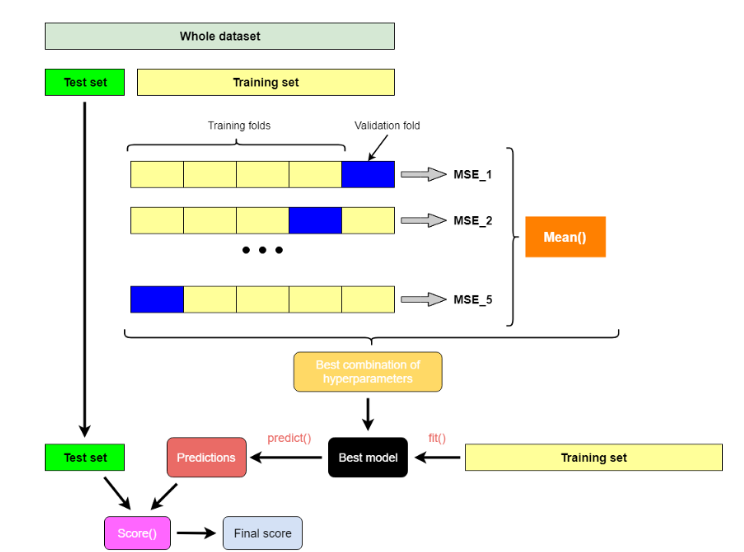

In [ ]:
#@title Default title text
# Normal_data_train, Normal_data_test = Percent_data_split(G_data_N_DE_1, G_data_N_DE_1, percent_1 = 80, index_1 = False)
# Normal_data_train, Normal_data_valid = Percent_data_split(Normal_data_train, Normal_data_train, percent_1 = 50, index_1 = False)
# print('Original Nominal Data before slicing',G_data_N_DE.shape)
# print("Normal_data_train", Normal_data_train.shape)
# print("Normal_data_valid", Normal_data_valid.shape)
# print("Normal_data_test", Normal_data_test.shape)
# 
# Faulty_data_train, Faulty_data_test = Percent_data_split(G_data_faulty_DE_1, G_data_faulty_DE_1, percent_1 = 80, index_1 = False)
# Faulty_data_train, Faulty_data_valid = Percent_data_split(Faulty_data_train, Faulty_data_train, percent_1 = 50, index_1 = False)
# print('Original Faulty Data before slicing',G_data_faulty.shape)
# print("Faulty_data_train", Faulty_data_train.shape)
# print("Faulty_data_valid", Faulty_data_valid.shape)
# print("Faulty_data_test", Faulty_data_test.shape)

In [ ]:
#@title Default title text
# Normal_data_train, Normal_data_test = Percent_data_split(G_data_N_DE_1, G_data_N_DE_1, percent_1 = 80, index_1 = False)
# Normal_data_train, Normal_data_valid = Percent_data_split(Normal_data_train, Normal_data_train, percent_1 = 50, index_1 = False)
# print('Original Nominal Data before slicing',G_data_N_DE.shape)
# print("Normal_data_train", Normal_data_train.shape)
# print("Normal_data_valid", Normal_data_valid.shape)
# print("Normal_data_test", Normal_data_test.shape)
# 
# Ball_data_train, Ball_data_test = Percent_data_split(G_data_B_DE_1, G_data_B_DE_1, percent_1 = 80, index_1 = False)
# Ball_data_train, Ball_data_valid = Percent_data_split(Ball_data_train, Ball_data_train, percent_1 = 50, index_1 = False)
# print('Original Ball bearing faulty Data before slicing', G_data_B_DE.shape)
# print("Ball_data_train", Ball_data_train.shape)
# print("Ball_data_valid", Ball_data_valid.shape)
# print("Ball_data_test", Ball_data_test.shape)
# 
# IR_data_train, IR_data_test =  Percent_data_split(G_data_IR_DE_1, G_data_IR_DE_1, percent_1 = 80, index_1 = False)
# IR_data_train, IR_data_valid =  Percent_data_split(IR_data_train, IR_data_train, percent_1 = 50, index_1 = False)
# print('Original Inner race fault Data before slicing', G_data_IR_DE.shape)
# print("IR_data_train", IR_data_train.shape)
# print("IR_data_valid", IR_data_valid.shape)
# print("IR_data_test", IR_data_test.shape)
# 
# OR_data_train, OR_data_test =  Percent_data_split(G_data_OR_DE_1, G_data_OR_DE_1, percent_1 = 80, index_1 = False)
# OR_data_train, OR_data_valid =  Percent_data_split(OR_data_train, OR_data_train, percent_1 = 50, index_1 = False)
# print('Original Outer race fault Data before slicing', G_data_OR_DE.shape)
# print("OR_data_train", OR_data_train.shape)
# print("OR_data_valid", OR_data_valid.shape)
# print("OR_data_test", OR_data_test.shape)

In [ ]:
#@title Default title text
Normal_data_train, Normal_data_test = Percent_data_split(G_data_N_DE_1, G_data_N_DE_1, percent_1 = 80, index_1 = False)
Normal_data_train, Normal_data_valid = Percent_data_split(Normal_data_train, Normal_data_train, percent_1 = 50, index_1 = False)
print('Original Nominal Data before slicing',G_data_N_DE.shape)
print("Normal_data_train", Normal_data_train.shape)
print("Normal_data_valid", Normal_data_valid.shape)
print("Normal_data_test", Normal_data_test.shape)

Ball_data_train_007, Ball_data_test_007 = Percent_data_split(G_data_B_007_DE_1, G_data_B_007_DE_1, percent_1 = 80, index_1 = False)
Ball_data_train_007, Ball_data_valid_007 = Percent_data_split(Ball_data_train_007, Ball_data_train_007, percent_1 = 50, index_1 = False)
print('Original Ball bearing fault diameter 007 Data before slicing', G_data_B_007_DE.shape)
print("Ball_data_train_007", Ball_data_train_007.shape)
print("Ball_data_valid_007", Ball_data_valid_007.shape)
print("Ball_data_test_007", Ball_data_test_007.shape)

Ball_data_train_014, Ball_data_test_014 = Percent_data_split(G_data_B_014_DE_1, G_data_B_014_DE_1, percent_1 = 80, index_1 = False)
Ball_data_train_014, Ball_data_valid_014 = Percent_data_split(Ball_data_train_014, Ball_data_train_014, percent_1 = 50, index_1 = False)
print('Original Ball bearing fault diameter 014 Data before slicing', G_data_B_014_DE.shape)
print("Ball_data_trai_014n", Ball_data_train_014.shape)
print("Ball_data_valid_014", Ball_data_valid_014.shape)
print("Ball_data_test_014", Ball_data_test_014.shape)

Ball_data_train_021, Ball_data_test_021 = Percent_data_split(G_data_B_021_DE_1, G_data_B_021_DE_1, percent_1 = 80, index_1 = False)
Ball_data_train_021, Ball_data_valid_021 = Percent_data_split(Ball_data_train_021, Ball_data_train_021, percent_1 = 50, index_1 = False)
print('Original Ball bearing fault diameter 021 Data before slicing', G_data_B_021_DE.shape)
print("Ball_data_train_021", Ball_data_train_021.shape)
print("Ball_data_valid_021", Ball_data_valid_021.shape)
print("Ball_data_test_021", Ball_data_test_021.shape)

IR_data_train_007, IR_data_test_007 =  Percent_data_split(G_data_IR_007_DE_1, G_data_IR_007_DE_1, percent_1 = 80, index_1 = False)
IR_data_train_007, IR_data_valid_007 =  Percent_data_split(IR_data_train_007, IR_data_train_007, percent_1 = 50, index_1 = False)
print('Original Inner race fault diameter 007 Data before slicing', G_data_IR_007_DE.shape)
print("IR_data_train_007", IR_data_train_007.shape)
print("IR_data_valid_007", IR_data_valid_007.shape)
print("IR_data_test_007", IR_data_test_007.shape)

IR_data_train_014, IR_data_test_014 =  Percent_data_split(G_data_IR_014_DE_1, G_data_IR_014_DE_1, percent_1 = 80, index_1 = False)
IR_data_train_014, IR_data_valid_014 =  Percent_data_split(IR_data_train_014, IR_data_train_014, percent_1 = 50, index_1 = False)
print('Original Inner race fault diameter 014 Data before slicing', G_data_IR_014_DE.shape)
print("IR_data_train_014", IR_data_train_014.shape)
print("IR_data_valid_014", IR_data_valid_014.shape)
print("IR_data_test_014", IR_data_test_014.shape)

IR_data_train_021, IR_data_test_021 =  Percent_data_split(G_data_IR_021_DE_1, G_data_IR_021_DE_1, percent_1 = 80, index_1 = False)
IR_data_train_021, IR_data_valid_021 =  Percent_data_split(IR_data_train_021, IR_data_train_021, percent_1 = 50, index_1 = False)
print('Original Inner race fault diameter 021 Data before slicing', G_data_IR_021_DE.shape)
print("IR_data_train_021", IR_data_train_021.shape)
print("IR_data_valid_021", IR_data_valid_021.shape)
print("IR_data_test_021", IR_data_test_021.shape)

OR_data_train_007, OR_data_test_007 =  Percent_data_split(G_data_OR_007_DE_1, G_data_OR_007_DE_1, percent_1 = 80, index_1 = False)
OR_data_train_007, OR_data_valid_007 =  Percent_data_split(OR_data_train_007, OR_data_train_007, percent_1 = 50, index_1 = False)
print('Original Outer race fault diameter 007 Data before slicing', G_data_OR_007_DE.shape)
print("OR_data_train_007", OR_data_train_007.shape)
print("OR_data_valid_007", OR_data_valid_007.shape)
print("OR_data_test_007", OR_data_test_007.shape)
 
OR_data_train_014, OR_data_test_014 =  Percent_data_split(G_data_OR_014_DE_1, G_data_OR_014_DE_1, percent_1 = 80, index_1 = False)
OR_data_train_014, OR_data_valid_014 =  Percent_data_split(OR_data_train_014, OR_data_train_014, percent_1 = 50, index_1 = False)
print('Original Outer race fault diameter 014 Data before slicing', G_data_OR_014_DE.shape)
print("OR_data_train_014", OR_data_train_014.shape)
print("OR_data_valid_014", OR_data_valid_014.shape)
print("OR_data_test_014", OR_data_test_014.shape)

OR_data_train_021, OR_data_test_021 =  Percent_data_split(G_data_OR_021_DE_1, G_data_OR_021_DE_1, percent_1 = 80, index_1 = False)
OR_data_train_021, OR_data_valid_021 =  Percent_data_split(OR_data_train_021, OR_data_train_021, percent_1 = 50, index_1 = False)
print('Original Outer race fault diameter 021 Data before slicing', G_data_OR_021_DE.shape)
print("OR_data_train_021", OR_data_train_021.shape)
print("OR_data_valid_021", OR_data_valid_021.shape)
print("OR_data_test_021", OR_data_test_021.shape)

Original Nominal Data before slicing (1698547,)
Normal_data_train (56, 32, 32)
Normal_data_valid (56, 32, 32)
Normal_data_test (29, 32, 32)
Original Ball bearing fault diameter 007 Data before slicing (487093,)
Ball_data_train_007 (16, 32, 32)
Ball_data_valid_007 (16, 32, 32)
Ball_data_test_007 (8, 32, 32)
Original Ball bearing fault diameter 014 Data before slicing (488109,)
Ball_data_trai_014n (16, 32, 32)
Ball_data_valid_014 (16, 32, 32)
Ball_data_test_014 (8, 32, 32)
Original Ball bearing fault diameter 021 Data before slicing (487964,)
Ball_data_train_021 (16, 32, 32)
Ball_data_valid_021 (16, 32, 32)
Ball_data_test_021 (8, 32, 32)
Original Inner race fault diameter 007 Data before slicing (488309,)
IR_data_train_007 (16, 32, 32)
IR_data_valid_007 (16, 32, 32)
IR_data_test_007 (8, 32, 32)
Original Inner race fault diameter 014 Data before slicing (487239,)
IR_data_train_014 (16, 32, 32)
IR_data_valid_014 (16, 32, 32)
IR_data_test_014 (8, 32, 32)
Original Inner race fault diameter 0

In [ ]:
def store_sp_images(list_of_items):
    print(f"name of data passed {namestr(list_of_items, globals())} and shape {list_of_items.shape}")
    store = []
    for i in range(len(list_of_items[:,0])):
        i = list_of_items[i]
        i = np.array(i)
        # print(i.shape)
        i = i[:, :, np.newaxis]
        i = np.repeat(i, repeats = 3, axis = -1)
        store.append(i)

    return np.array(store)


In [ ]:
# Normal_train = store_sp_images(Normal_data_train)
# Normal_valid = store_sp_images(Normal_data_valid)
# Normal_test  = store_sp_images(Normal_data_test)
# 
# Faulty_train = store_sp_images(Faulty_data_train)
# Faulty_valid = store_sp_images(Faulty_data_valid)
# Faulty_test  = store_sp_images(Faulty_data_test)

In [ ]:
# Normal_train = store_sp_images(Normal_data_train)
# Normal_valid = store_sp_images(Normal_data_valid)
# Normal_test  = store_sp_images(Normal_data_test)
# 
# Ball_train   = store_sp_images(Ball_data_train)
# Ball_valid   = store_sp_images(Ball_data_valid)
# Ball_test    = store_sp_images(Ball_data_test)
# 
# IR_train     = store_sp_images(IR_data_train)
# IR_valid     = store_sp_images(IR_data_valid)
# IR_test      = store_sp_images(IR_data_test)
# 
# OR_train     = store_sp_images(OR_data_train)
# OR_valid     = store_sp_images(OR_data_valid)
# OR_test      = store_sp_images(OR_data_test)

In [ ]:
Normal_train   =   store_sp_images(np.array(Normal_data_train))
Normal_valid   =   store_sp_images(np.array(Normal_data_valid))
Normal_test    =    store_sp_images(np.array(Normal_data_test))

Ball_train_007 = store_sp_images(np.array(Ball_data_train_007))
Ball_valid_007 = store_sp_images(np.array(Ball_data_valid_007))
Ball_test_007  =  store_sp_images(np.array(Ball_data_test_007))

Ball_train_014 = store_sp_images(np.array(Ball_data_train_014))
Ball_valid_014 = store_sp_images(np.array(Ball_data_valid_014))
Ball_test_014  =  store_sp_images(np.array(Ball_data_test_014))

Ball_train_021 = store_sp_images(np.array(Ball_data_train_021))
Ball_valid_021 = store_sp_images(np.array(Ball_data_valid_021))
Ball_test_021  =  store_sp_images(np.array(Ball_data_test_021))

IR_train_007   =   store_sp_images(np.array(IR_data_train_007))
IR_valid_007   =   store_sp_images(np.array(IR_data_valid_007))
IR_test_007    =    store_sp_images(np.array(IR_data_test_007))
    
IR_train_014   =   store_sp_images(np.array(IR_data_train_014))
IR_valid_014   =   store_sp_images(np.array(IR_data_valid_014))
IR_test_014    =    store_sp_images(np.array(IR_data_test_014))
    
IR_train_021   =   store_sp_images(np.array(IR_data_train_021))
IR_valid_021   =   store_sp_images(np.array(IR_data_valid_021))
IR_test_021    =    store_sp_images(np.array(IR_data_test_021))
  
OR_train_007   =   store_sp_images(np.array(OR_data_train_007))
OR_valid_007   =   store_sp_images(np.array(OR_data_valid_007))
OR_test_007    =    store_sp_images(np.array(OR_data_test_007))
  
OR_train_014    =   store_sp_images(np.array(OR_data_train_014))
OR_valid_014    =   store_sp_images(np.array(OR_data_valid_014))
OR_test_014     =    store_sp_images(np.array(OR_data_test_014))
    
OR_train_021    =   store_sp_images(np.array(OR_data_train_021))
OR_valid_021    =   store_sp_images(np.array(OR_data_valid_021))
OR_test_021     =    store_sp_images(np.array(OR_data_test_021))

name of data passed [] and shape (56, 32, 32)
name of data passed [] and shape (56, 32, 32)
name of data passed [] and shape (29, 32, 32)
name of data passed [] and shape (16, 32, 32)
name of data passed [] and shape (16, 32, 32)
name of data passed [] and shape (8, 32, 32)
name of data passed [] and shape (16, 32, 32)
name of data passed [] and shape (16, 32, 32)
name of data passed [] and shape (8, 32, 32)
name of data passed [] and shape (16, 32, 32)
name of data passed [] and shape (16, 32, 32)
name of data passed [] and shape (8, 32, 32)
name of data passed [] and shape (16, 32, 32)
name of data passed [] and shape (16, 32, 32)
name of data passed [] and shape (8, 32, 32)
name of data passed [] and shape (16, 32, 32)
name of data passed [] and shape (16, 32, 32)
name of data passed [] and shape (8, 32, 32)
name of data passed [] and shape (16, 32, 32)
name of data passed [] and shape (16, 32, 32)
name of data passed [] and shape (8, 32, 32)
name of data passed [] and shape (48, 32

## 4.4 Preparing Train-Test Data

### 4.4.1 Image loading

Now to define a function that loads the images that were generated.

With the aid of the previous function the images for DE and `TRAIN` is loaded. 

With the aid of the previous function, the images for DE and `VALIDATION` are loaded.

With the aid of the previous function, the images for DE and `TEST` are loaded.

In [ ]:
def give_image_a_label(images, label):
    storage = []
    for i in range(images.shape[0]):
        storage.append(label)

    return np.array(storage).astype(np.float32)

In [ ]:
# Normal_train_y =  give_image_a_label(Normal_data_train, 0)
# Normal_valid_y =  give_image_a_label(Normal_data_valid, 0)
# Normal_test_y  =  give_image_a_label(Normal_data_test, 0)
# 
# Faulty_train_y =  give_image_a_label(Faulty_data_train, 1)
# Faulty_valid_y =  give_image_a_label(Faulty_data_valid, 1)
# Faulty_test_y  =  give_image_a_label(Faulty_data_test, 1)

In [ ]:
# Normal_train_y =  give_image_a_label(Normal_train, 0)
# Normal_valid_y =  give_image_a_label(Normal_valid, 0)
# Normal_test_y  =  give_image_a_label(Normal_test, 0)
# 
# Ball_train_y =  give_image_a_label(Ball_train, 1)
# Ball_valid_y =  give_image_a_label(Ball_valid, 1)
# Ball_test_y  =  give_image_a_label(Ball_test, 1)
# 
# IR_train_y =  give_image_a_label(IR_train, 2)
# IR_valid_y =  give_image_a_label(IR_valid, 2)
# IR_test_y  =  give_image_a_label(IR_test, 2)
# 
# OR_train_y =  give_image_a_label(OR_train, 3)
# OR_valid_y =  give_image_a_label(OR_valid, 3)
# OR_test_y  =  give_image_a_label(OR_test, 3)

In [ ]:
Normal_train_y =  give_image_a_label(Normal_train, 0)
Normal_valid_y =  give_image_a_label(Normal_valid, 0)
Normal_test_y  =  give_image_a_label(Normal_test, 0)

Ball_train_007_y = give_image_a_label(Ball_train_007, 1)
Ball_valid_007_y = give_image_a_label(Ball_valid_007, 1)
Ball_test_007_y =  give_image_a_label(Ball_test_007, 1)

Ball_train_014_y = give_image_a_label(Ball_train_014, 2)
Ball_valid_014_y = give_image_a_label(Ball_valid_014, 2)
Ball_test_014_y  =  give_image_a_label(Ball_test_014, 2)

Ball_train_021_y = give_image_a_label(Ball_train_021, 3)
Ball_valid_021_y = give_image_a_label(Ball_valid_021, 3)
Ball_test_021_y  =  give_image_a_label(Ball_test_021, 3)

IR_train_007_y = give_image_a_label(IR_train_007, 4)
IR_valid_007_y = give_image_a_label(IR_valid_007, 4)
IR_test_007_y  =  give_image_a_label(IR_test_007, 4)

IR_train_014_y = give_image_a_label(IR_train_014, 5)
IR_valid_014_y = give_image_a_label(IR_valid_014, 5)
IR_test_014_y  =  give_image_a_label(IR_test_014, 5)

IR_train_021_y = give_image_a_label(IR_train_021, 6)
IR_valid_021_y = give_image_a_label(IR_valid_021, 6)
IR_test_021_y  =  give_image_a_label(IR_test_021, 6)

OR_train_007_y = give_image_a_label(OR_train_007, 7)
OR_valid_007_y = give_image_a_label(OR_valid_007, 7)
OR_test_007_y  =  give_image_a_label(OR_test_007, 7)

OR_train_014_y = give_image_a_label(OR_train_014, 8)
OR_valid_014_y = give_image_a_label(OR_valid_014, 8)
OR_test_014_y  =  give_image_a_label(OR_test_014, 8)

OR_train_021_y = give_image_a_label(OR_train_021, 9)
OR_valid_021_y = give_image_a_label(OR_valid_021, 9)
OR_test_021_y  =  give_image_a_label(OR_test_021, 9)

In [ ]:
# y_train = np.concatenate((Normal_train_y, Faulty_train_y), axis=0)
# 
# y_valid = np.concatenate((Normal_valid_y, Faulty_valid_y), axis=0)
# 
# y_test = np.concatenate((Normal_test_y, Faulty_test_y), axis=0)
# 
# print(y_train.shape)
# print(y_valid.shape)
# print(y_test.shape)

In [ ]:
# y_train = np.concatenate((Normal_train_y, Ball_train_y, IR_train_y, OR_train_y), axis=0)
# 
# y_valid = np.concatenate((Normal_valid_y, Ball_valid_y, IR_valid_y, OR_valid_y), axis=0)
# 
# y_test = np.concatenate((Normal_test_y, Ball_test_y, IR_test_y, OR_test_y), axis=0)
# 
# print(y_train.shape)
# print(y_valid.shape)
# print(y_test.shape)

In [ ]:
y_train = np.concatenate((Normal_train_y, Ball_train_007_y, Ball_train_014_y, Ball_train_021_y,
                                          IR_train_007_y, IR_train_014_y, IR_train_021_y,
                                          OR_train_007_y, OR_train_014_y, OR_train_021_y), axis=0)

y_valid = np.concatenate((Normal_valid_y, Ball_valid_007_y, Ball_valid_014_y, Ball_valid_021_y,
                                          IR_valid_007_y, IR_valid_014_y, IR_valid_021_y,
                                          OR_valid_007_y, OR_valid_014_y, OR_valid_021_y), axis=0)

y_test = np.concatenate((Normal_test_y, Ball_test_007_y, Ball_test_014_y, Ball_test_021_y,
                                        IR_test_007_y, IR_test_014_y, IR_test_021_y,
                                        OR_test_007_y, OR_test_014_y, OR_test_021_y), axis=0)

print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(264,)
(266,)
(135,)


In [ ]:
# X_train = np.concatenate((Normal_train, Faulty_train), axis=0)
# 
# X_valid = np.concatenate((Normal_valid, Faulty_valid), axis=0)
# 
# X_test = np.concatenate((Normal_test, Faulty_test), axis=0)
# 
# print(X_train.shape)
# print(X_valid.shape)
# print(X_test.shape)

In [ ]:
# X_train = np.concatenate((Normal_train, Ball_train, IR_train, OR_train), axis=0)
# 
# X_valid = np.concatenate((Normal_valid, Ball_valid, IR_valid, OR_valid), axis=0)
# 
# X_test = np.concatenate((Normal_test, Ball_test, IR_test, OR_test), axis=0)
# 
# print(X_train.shape)
# print(X_valid.shape)
# print(X_test.shape)

In [ ]:
X_train = np.concatenate((Normal_train, Ball_train_007, Ball_train_014, Ball_train_021, IR_train_007, IR_train_014, IR_train_021, OR_train_007,  OR_train_014,  OR_train_021), axis=0)

X_valid = np.concatenate((Normal_valid, Ball_valid_007, Ball_valid_014, Ball_valid_021, IR_valid_007, IR_valid_014, IR_valid_021, OR_valid_007,  OR_valid_014,  OR_valid_021), axis=0)

X_test =   np.concatenate((Normal_test, Ball_test_007,  Ball_test_014,  Ball_test_021,  IR_test_007,  IR_test_014,  IR_test_021,  OR_test_007,   OR_test_014,   OR_test_021), axis=0)

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(264, 32, 32, 3)
(266, 32, 32, 3)
(135, 32, 32, 3)


In [ ]:
from torch.utils.data import Dataset, TensorDataset, DataLoader
class CustomTensorDataset(Dataset):
    """ TensorDataset with support of transforms.
    """
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)

def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  
  image = image.transpose(1, 2, 0)
  image = image.clip(0, 1)
  return image

In [ ]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_valid = torch.tensor(X_valid, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

y_train = torch.tensor(np.array(y_train).astype(np.float32)).type(torch.LongTensor)
y_valid = torch.tensor(np.array(y_valid).astype(np.float32)).type(torch.LongTensor)
y_test = torch.tensor(np.array(y_test).astype(np.float32)).type(torch.LongTensor)

In [ ]:
X_train = X_train.permute(0, 3, 1, 2)
X_valid = X_valid.permute(0, 3, 1, 2)
X_test = X_test.permute(0, 3, 1, 2)

In [ ]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

torch.Size([264, 3, 32, 32])
torch.Size([266, 3, 32, 32])
torch.Size([135, 3, 32, 32])


In [ ]:
train_ds = CustomTensorDataset(tensors =  (X_train, y_train))
valid_ds = CustomTensorDataset(tensors =  (X_valid, y_valid))
test_ds = CustomTensorDataset(tensors  =  (X_test, y_test))

In [ ]:
image_datasets = {}
image_datasets['train'] = train_ds
image_datasets['valid'] = valid_ds
image_datasets['test']  = test_ds

dataloaders = {'train': DataLoader(image_datasets['train'], batch_size=16, shuffle=True),
               'valid': DataLoader(image_datasets['valid'], batch_size=16, shuffle=True),
               'test': DataLoader(image_datasets['test'], batch_size=16, shuffle=True)
              } 

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
class_names = classes

### If all images are Dark, please don't worry, because plt.imshow doesn't display spectrogram correctly, but the images are exactly like the ones on top

torch.Size([16, 3, 32, 32])


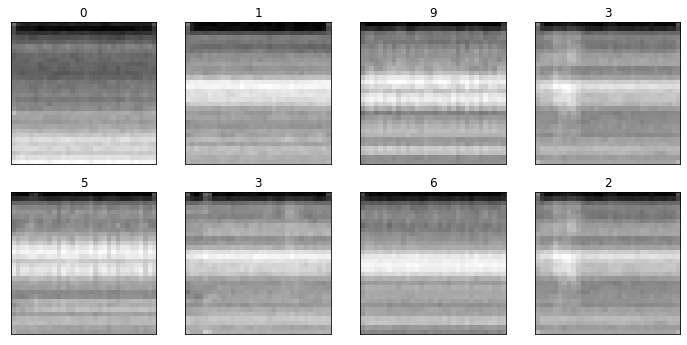

In [ ]:
dataiter = iter(dataloaders['train'])
images, labels = dataiter.next()
print(images.shape)
fig = plt.figure(figsize=(12, 12))
 
for idx in np.arange(8):
  ax = fig.add_subplot(4, 4, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]), origin='lower', aspect='auto')
  ax.set_title(classes[labels[idx].item()])

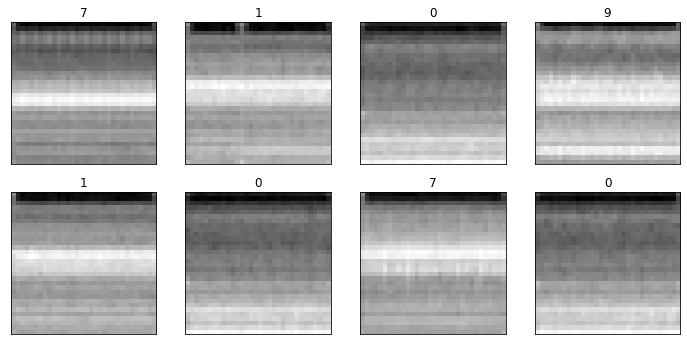

In [ ]:
dataiter = iter(dataloaders['valid'])
images, labels = dataiter.next()
fig = plt.figure(figsize=(12, 12))
 
for idx in np.arange(8):
  ax = fig.add_subplot(4, 4, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]), origin='lower', aspect='auto')
  ax.set_title(classes[labels[idx].item()])

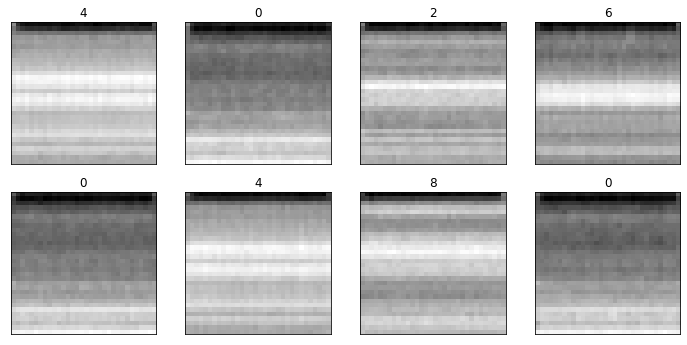

In [ ]:
dataiter = iter(dataloaders['test'])
images, labels = dataiter.next()
fig = plt.figure(figsize=(12, 12))
 
for idx in np.arange(8):
  ax = fig.add_subplot(4, 4, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]), origin='lower', aspect='auto')
  ax.set_title(classes[labels[idx].item()])

## Convolutional Neural Network
The CNN architecture used in this notebook is from the paper Deep Learning Enabled Fault Diagnosis Using Time-Frequency Image Analysis of Rolling Element Bearings. It is a proposed architecture. This architecture is used due to the resolution of the image and it yields very good results in terms of precision.

## CNN model with Pytorch
It is a supervised classification problem, with 10 classes. A Convolutional Neural Network (CNN) is implemented as a pytorch model.

The loss function is categorical cross-entropy, the optimizer is ADAM and Leaky RELU is the activation function used after each Convolution layer. The learning rate has been tested to different values and in the end learning rate decay was followed manually for that matter.

In [ ]:
# Model instantiation, Pretrained weights and biases

model_resnet18 = models.resnet18(weights=True)

num_ftrs = model_resnet18.fc.in_features

model_resnet18.fc = nn.Linear(num_ftrs, 10)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model_resnet18 = model_resnet18.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
torch.manual_seed(42)

criterion = nn.CrossEntropyLoss()

dataset = ConcatDataset([train_ds, valid_ds])

num_epochs=100
batch_size=16
k=5

splits=KFold(n_splits=k,shuffle=True,random_state=42)
foldperf={}

In [ ]:
def train_epoch(model,device,dataloader,loss_fn,optimizer):
    train_loss,train_correct=0.0,0
    model.train()
    for images, labels in dataloader:

        images,labels = images.to(device),labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = loss_fn(output,labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(output.data, 1)
        train_correct += (predictions == labels).sum().item()

    return train_loss,train_correct, model
  
def valid_epoch(model,device,dataloader,loss_fn):
    valid_loss, val_correct = 0.0, 0
    model.eval()
    for images, labels in dataloader:

        images,labels = images.to(device),labels.to(device)
        output = model(images)
        loss=loss_fn(output,labels)
        valid_loss+=loss.item()*images.size(0)
        scores, predictions = torch.max(output.data,1)
        val_correct+=(predictions == labels).sum().item()

    return valid_loss,val_correct, model

In [ ]:
import copy
best_model = None
best_accuracy = -1
for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(dataset)))):

    print('Fold {}'.format(fold + 1))

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)
    

    model_resnet18 = models.resnet18(pretrained=True)
    num_ftrs = model_resnet18.fc.in_features
    model_resnet18.fc = nn.Linear(num_ftrs, 10)

    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    model = model_resnet18.to(device)

    optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9,0.999), weight_decay=1e-2)

    history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}

    for epoch in range(num_epochs):
        train_loss, train_correct, model = train_epoch(model,device,train_loader,criterion,optimizer)
        test_loss, test_correct, model = valid_epoch(model,device,test_loader,criterion)

        train_loss = train_loss / len(train_loader.sampler)
        train_acc = train_correct / len(train_loader.sampler) * 100
        test_loss = test_loss / len(test_loader.sampler)
        test_acc = test_correct / len(test_loader.sampler) * 100

        print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Test Loss:{:.3f} "
         "AVG Training Acc {:.2f} % AVG Test Acc {:.2f} %".format(epoch + 1,num_epochs,train_loss,test_loss,train_acc,test_acc))

        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)

    foldperf['fold{}'.format(fold+1)] = history

    #save best model
    accuracy =  np.array(history['test_acc']).max()
    if (accuracy > best_accuracy).all():
      
       # path to save models to:
       path = '/content/Saved_models'
       best_model = copy.deepcopy(model)
       model_saved = torch.save(best_model.state_dict(), path + ' best-model.pt')
  
    del model
    del optimizer  


Fold 1
Epoch:1/100 AVG Training Loss:1.618 AVG Test Loss:2.352 AVG Training Acc 50.00 % AVG Test Acc 17.92 %
Epoch:2/100 AVG Training Loss:0.520 AVG Test Loss:1.011 AVG Training Acc 85.85 % AVG Test Acc 76.42 %
Epoch:3/100 AVG Training Loss:0.283 AVG Test Loss:0.573 AVG Training Acc 91.27 % AVG Test Acc 81.13 %
Epoch:4/100 AVG Training Loss:0.234 AVG Test Loss:0.350 AVG Training Acc 92.22 % AVG Test Acc 82.08 %
Epoch:5/100 AVG Training Loss:0.161 AVG Test Loss:0.426 AVG Training Acc 93.63 % AVG Test Acc 85.85 %
Epoch:6/100 AVG Training Loss:0.208 AVG Test Loss:0.412 AVG Training Acc 92.69 % AVG Test Acc 85.85 %
Epoch:7/100 AVG Training Loss:0.141 AVG Test Loss:0.365 AVG Training Acc 95.05 % AVG Test Acc 85.85 %
Epoch:8/100 AVG Training Loss:0.144 AVG Test Loss:0.509 AVG Training Acc 94.34 % AVG Test Acc 83.02 %
Epoch:9/100 AVG Training Loss:0.130 AVG Test Loss:0.575 AVG Training Acc 95.52 % AVG Test Acc 83.96 %
Epoch:10/100 AVG Training Loss:0.162 AVG Test Loss:0.348 AVG Training Acc 9

In [ ]:
testl_f,tl_f,testa_f,ta_f=[],[],[],[]
k=5
for f in range(1,k+1):

     tl_f.append(np.mean(foldperf['fold{}'.format(f)]['train_loss']))
     testl_f.append(np.mean(foldperf['fold{}'.format(f)]['test_loss']))

     ta_f.append(np.mean(foldperf['fold{}'.format(f)]['train_acc']))
     testa_f.append(np.mean(foldperf['fold{}'.format(f)]['test_acc']))

print('Performance of {} fold cross validation'.format(k))
print("Average Training Loss: {:.3f} \t Average Test Loss: {:.3f} \t Average Training Acc: {:.2f} \t Average Test Acc: {:.2f}".format(np.mean(tl_f),np.mean(testl_f),np.mean(ta_f),np.mean(testa_f)))

Performance of 5 fold cross validation
Average Training Loss: 0.139 	 Average Test Loss: 0.263 	 Average Training Acc: 92.92 	 Average Test Acc: 89.42


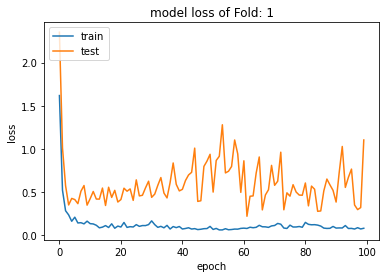

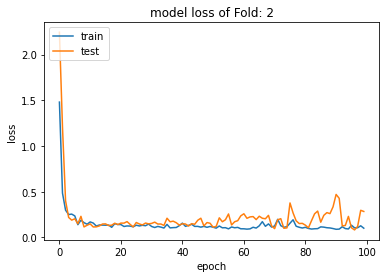

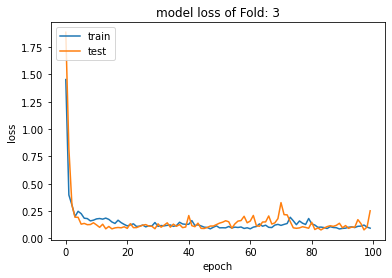

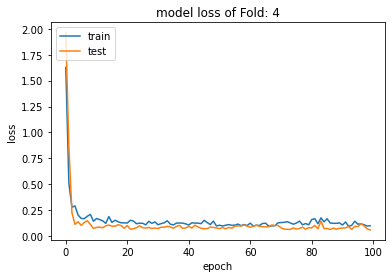

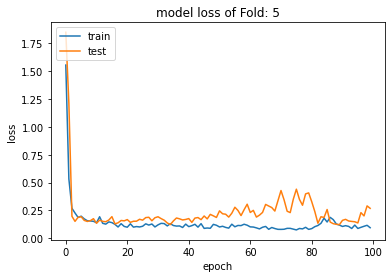

In [ ]:
k=5
for f in range(1,k+1):
    tl_f = foldperf['fold{}'.format(f)]['train_loss']
    testl_f = foldperf['fold{}'.format(f)]['test_loss']
    plt.plot(tl_f)
    plt.plot(testl_f)
    plt.title(f'model loss of Fold: {f}')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
del tl_f, testl_f

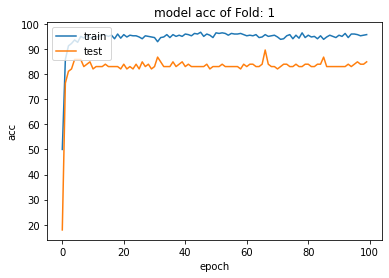

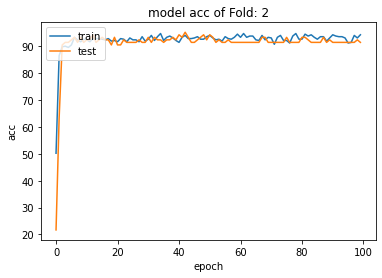

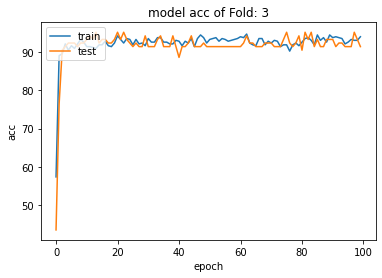

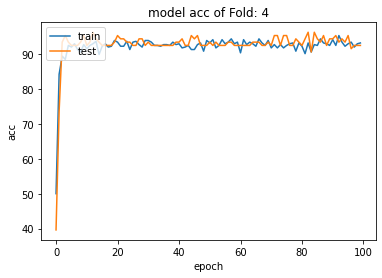

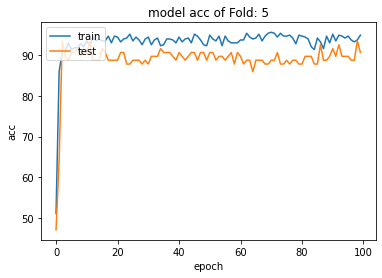

In [ ]:
k=5
for f in range(1,k+1):
    ta_f = foldperf['fold{}'.format(f)]['train_acc']
    testa_f = foldperf['fold{}'.format(f)]['test_acc']
    plt.plot(ta_f)
    plt.plot(testa_f)
    plt.title(f'model acc of Fold: {f}')
    plt.ylabel('acc')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

## 5.9 Confusion matrix: 

In [ ]:
del zip
del ZipFile

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model_resnet18 = models.resnet18(pretrained=True)
num_ftrs = model_resnet18.fc.in_features
model_resnet18.fc = nn.Linear(num_ftrs, 10)
model = model_resnet18.to(device)

model.load_state_dict(torch.load('/content/Saved_models best-model.pt'))

<All keys matched successfully>

Text(0.5, 86.09375, 'Predicted Label')

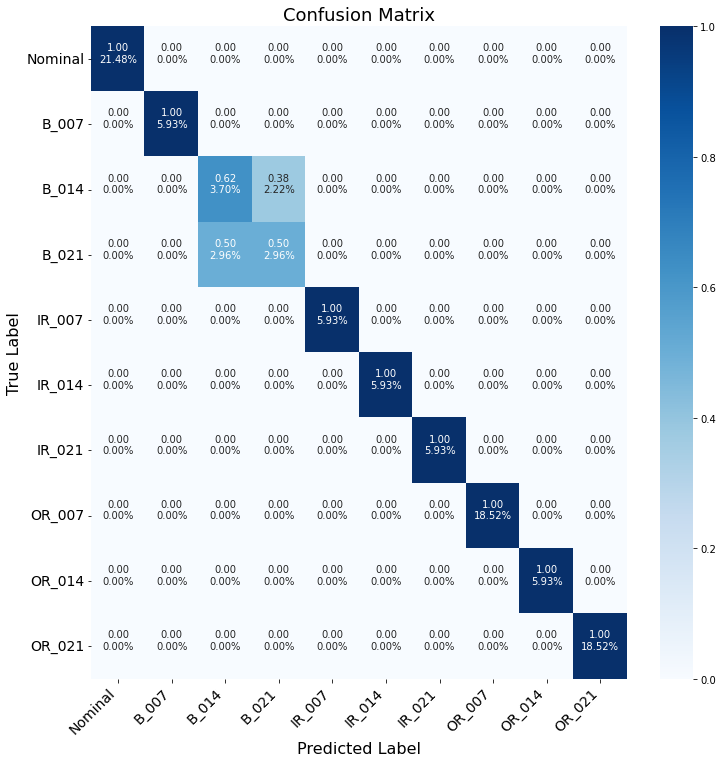

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

nb_classes = 10

confusion_matrix = np.zeros((nb_classes, nb_classes))
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['test']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

# Normalise
cmn = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12,12))

group_names = ('Nominal', 'Faulty')

group_counts = ["{0:.2f}".format(value) for value in
                cmn.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     confusion_matrix.flatten()/np.sum(confusion_matrix)]

labels = [f"{v1}\n{v2}\n" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(10,10)

class_names = ('Nominal', 'B_007', 'B_014', 'B_021', 'IR_007', 'IR_014', 'IR_021', 'OR_007', 'OR_014', 'OR_021')

ax = sns.heatmap(cmn, annot=labels, fmt='', cmap='Blues',  xticklabels=class_names, yticklabels=class_names)

ax.yaxis.set_ticklabels(ax.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=14)
ax.xaxis.set_ticklabels(ax.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=14)
plt.title('Confusion Matrix', fontsize=18)
plt.ylabel('True Label', fontsize=16)
plt.xlabel('Predicted Label', fontsize=16)

# class_names = ('Nominal', 'B_007', 'B_014', 'B_021', 'IR_007', 'IR_014', 'IR_021', 'OR_007', 'OR_014', 'OR_021')
# class_names = ('Nominal', 'B_B', 'B_IR','B_OR')
# group_names = ('Nominal', 'Faulty')

# 6. ROC analysis

The ROC curves for each class give a complete picture of the classification performance of the CNN. The function below performs this task.

## 6.1 ROC curve, Confusion matrix and accuracies

In [ ]:
import torch
import torch.nn as nn
import os
import numpy as np
from torchvision.datasets import ImageFolder
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc, f1_score, precision_recall_curve, average_precision_score

num_class = 10  
gpu = "cuda:0"  


def test(model, dataloaders_name='test'):

    model.eval()

    score_list = []     
    label_list = []     
    for i, (inputs, labels) in enumerate(dataloaders[dataloaders_name]):
        inputs = inputs.cuda()
        labels = labels.cuda()

        outputs = model(inputs)
        
        score_tmp = outputs  

        score_list.extend(score_tmp.detach().cpu().numpy())
        label_list.extend(labels.cpu().numpy())

    score_array = np.array(score_list)
    # 将label转换成onehot形式
    label_tensor = torch.tensor(label_list)
    label_tensor = label_tensor.reshape((label_tensor.shape[0], 1))
    label_onehot = torch.zeros(label_tensor.shape[0], num_class)
    label_onehot.scatter_(dim=1, index=label_tensor, value=1)
    label_onehot = np.array(label_onehot)

    print("score_array:", score_array.shape)  # (batchsize, classnum)
    print("label_onehot:", label_onehot.shape)  # torch.Size([batchsize, classnum])

    # 调用sklearn库，计算每个类别对应的fpr和tpr
    fpr_dict = dict()
    tpr_dict = dict()
    roc_auc_dict = dict()
    for i in range(num_class):
        fpr_dict[i], tpr_dict[i], _ = roc_curve(label_onehot[:, i], score_array[:, i])
        roc_auc_dict[i] = auc(fpr_dict[i], tpr_dict[i])
    # micro
    fpr_dict["micro"], tpr_dict["micro"], _ = roc_curve(label_onehot.ravel(), score_array.ravel())
    roc_auc_dict["micro"] = auc(fpr_dict["micro"], tpr_dict["micro"])

    # macro
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr_dict[i] for i in range(num_class)]))
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_class):
        mean_tpr += interp(all_fpr, fpr_dict[i], tpr_dict[i])
    # Finally average it and compute AUC
    mean_tpr /= num_class
    fpr_dict["macro"] = all_fpr
    tpr_dict["macro"] = mean_tpr
    roc_auc_dict["macro"] = auc(fpr_dict["macro"], tpr_dict["macro"])

    # 绘制所有类别平均的roc曲线
    plt.figure(figsize=(12,12))
    lw = 2
    plt.plot(fpr_dict["micro"], tpr_dict["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc_dict["micro"]),
             color='deeppink', linestyle=':', linewidth=4)
    
    plt.plot(fpr_dict["macro"], tpr_dict["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc_dict["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['Black', 'Red', 'Green', 'Brown', 'Blue', 'Yellow', 'Purple', 'gray', 'aqua', 'pink'])
    for i, color in zip(range(num_class), colors):
        plt.plot(fpr_dict[i], tpr_dict[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                       ''.format(i, roc_auc_dict[i]))
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.savefig('set113_roc.jpg')
    plt.show()

score_array: (135, 10)
label_onehot: (135, 10)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


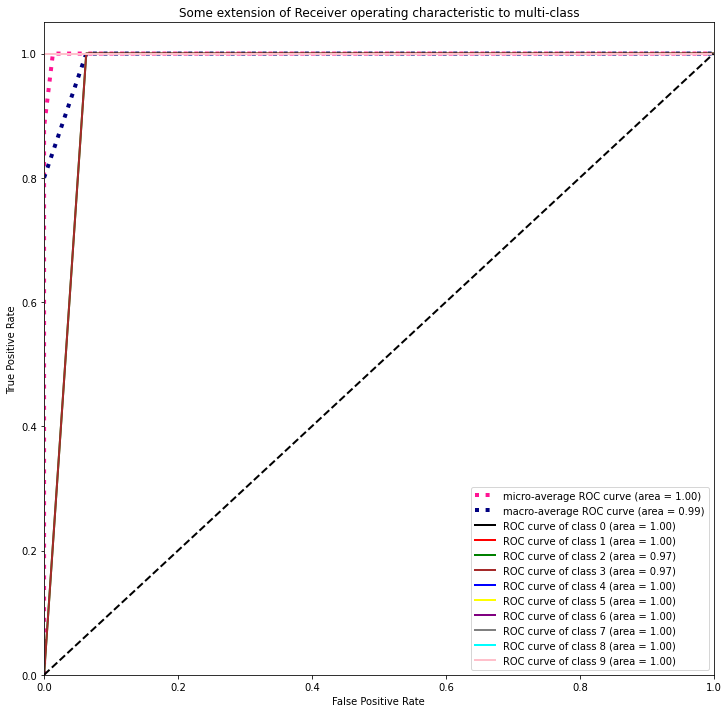

In [ ]:
model.load_state_dict(torch.load('/content/Saved_models best-model.pt'))

device = torch.device(gpu)
seresnet = model.to(device)
test(seresnet, 'test')